Click on your name and then profile to arrive your eScriptorium instance. If you are working on the main instance, that is `https://msia.escriptorium.fr/


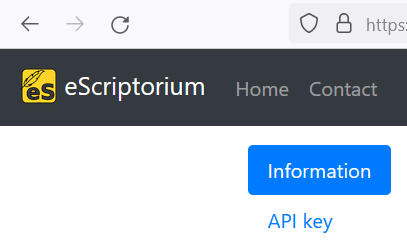

Then click on API and copy the alphanumeric code after "Token" (after and not including the :). This is your secret "token" which you should not share with anyone as it gives access to all data to which you have access whether your own or whether shared with you.

If you work on the msia instance replace `abe8934572784dea` with your code in the following cell.

If you work on another instance, you need to give it a name instead of `YOUR_SERVERNAME2`, replace YOURTOKEN2 with your token and replace "URL2" with the url (until but not including the first slash) of your instance.



In [ ]:
#@title initialization (seize your token and server and then run it)
%%writefile __init__.py
import copy
serverconnections = [{'servername':'$YOUR_INSTANCENAME_HERE', #choose freely
  'headers' : {'Authorization':'Token $YOURTOKEN_HERE'}, # as in UI
  'root_url' : 'YOUR_INSTANCE_URL_HERE'}]
  # you can add further instance or account connections if you have them

for serverconnection in serverconnections:
    serverconnection['headersbrief'] = copy.deepcopy(serverconnection['headers'])
    serverconnection['headers']['Content-type'] = 'application/json'
    serverconnection['headers']['Accept']= 'application/json'

if __name__ == '__main__':
  print("<> Running the module as a script! <>")

In [ ]:
#@title import modules - please run this cell to import functions

from __init__ import serverconnections

import sys
import json
import requests
import numpy
from numpy import rad2deg,deg2rad,array,atleast_2d,cos,sin,arctan2,squeeze,cross,linalg
import math
from math import sqrt
import os
import io
import re
import networkx as nx
import collections
from statistics import mean
from PIL import Image
from time import sleep
from scipy.optimize import linear_sum_assignment
from scipy.spatial import ConvexHull
from shapely import LineString
from shapely import intersection
from shapely.geometry import Point, Polygon
from shapely.ops import split as poly_split
import matplotlib.pyplot as plt
from google.colab import files
from typing import Any, Tuple, Union, List, Dict, Type, TypeVar
from imageio import imread

!pip install Levenshtein
import Levenshtein
#!pip install bidict
#import bidict
#!pip install xlsxwriter
#import xlsxwriter
!pip install xmltodict
import xmltodict


In [ ]:
# @title helper functions

def loop_through_itempages_and_get_all(base_url,suffix=''):
    result_list=[]
    def get_page(page,result_list):
        data = False
        #url = urljoin(base_url, '?page=%d' % page)
        if suffix=='':
          url = base_url+'?page='+str(page)
        else:
          url = base_url+'?page='+str(page)+'&'+suffix
        res = requests.get(url, headers=headers)
        #print(res.json())
        try:
            data = res.json()
        except json.decoder.JSONDecodeError as e:
            print('exception')
            print(res)
        else:
          if data:
            #print(data)
            result_list += [item for item in data['results']]
        if data:
          if data['next']:
            get_page(page+1,result_list)
    get_page(1,result_list)
    return(result_list)

def get_pks_of_dict_list(list_of_dictionaries):
    pks =[item['pk'] for item in list_of_dictionaries]
    return pks

def get_sthg_from_dict_list(list_of_dictionaries,sthg):
  return([item[sthg] for item in list_of_dictionaries])

# get_urls--------------------------------------------------------------------------------------------
def get_documents_url():
  return root_url+'/api/documents/'

def get_specific_doc_url(doc_pk):
  return get_documents_url()+str(doc_pk)+'/'

def get_parts_url(doc_pk):
  return get_specific_doc_url(doc_pk)+'parts/'

def get_specific_part_url(doc_pk,part_pk):
  return get_parts_url(doc_pk)+str(part_pk)+'/'

def get_metadata_url(doc_pk,part_pk):
  return get_specific_part_url(doc_pk,part_pk)+'metadata/'

def get_regions_url(doc_pk,part_pk):
  return get_specific_part_url(doc_pk,part_pk)+'blocks/'

def get_specific_region_url(doc_pk,part_pk,region_pk):
  return get_regions_url(doc_pk,part_pk)+str(region_pk)+'/'

def get_lines_url(doc_pk,part_pk):
  return get_specific_part_url(doc_pk,part_pk)+'lines/'

def get_specific_line_url(doc_pk,part_pk,line_pk):
  return get_lines_url(doc_pk,part_pk)+str(line_pk)+'/'

def get_doc_transcriptions_url(doc_pk):
  return get_specific_doc_url(doc_pk)+'transcriptions/'

def get_specific_transcription_level_url(doc_pk,tr_level):
  return get_doc_transcriptions_url(doc_pk)+str(tr_level)+'/'

def get_part_transcriptions_base_url(doc_pk,part_pk):
  return get_specific_part_url(doc_pk,part_pk)+'transcriptions/'

def get_part_transcriptions_url(doc_pk,part_pk,tr_level):
  return get_specific_part_url(doc_pk,part_pk)+'transcriptions/?transcription='+str(tr_level)+'&'

def get_specific_transcription_url(doc_pk,part_pk,tr_pk):
  return get_part_transcriptions_base_url+str(tr_pk)+'/'

def get_models_url():
  return root_url+'/api/models/'

def get_specific_model_url(model_pk):
  return get_models_url()+str(model_pk)+'/'

#def get_projects_url():
#  return root_url+'/api/projects/'

#def get_linetypes_url():
#  return root_url+'/api/types/lines/'

#def get_regiontypes_url():
#  return root_url+'/api/types/regions/'

#def get_annotationtypes_url():
#  return root_url+'/api/types/annotations/'

#def get_annotationtypes_url():
#  return root_url+'/api/types/part/'


def get_segmentation_url(doc_pk):
  return get_specific_doc_url(doc_pk)+'segment/'

def get_transcribe_url(doc_pk):
  return get_specific_doc_url(doc_pk)+'transcribe/'



  # search-and-sort-----------------------------------------------------------------------
def search(pk, list_of_dictionaries):
    result_list=[element for element in list_of_dictionaries if element['pk'] == pk]
    if len(result_list)==1:
      return result_list  [0]
    elif len(result_list)==0:
      return None
    else:
      return result_list

def search_any(key, value, list_of_dictionaries):
    return [element for element in list_of_dictionaries if element[key] == value]

def filter_dict_list(key,key_val_list,list_of_dictionaries):
  if (isinstance(key_val_list,str)) or (not(isinstance(key_val_list,list))):
    return search_any(key, key_val_list, list_of_dictionaries)
  else:
    return [row for row in list_of_dictionaries if row.get(key) in key_val_list]

def find_substr_in_str(str,substr):
  return [m for m in re.finditer(substr, str)]

def replace_substr_in_str(str,substr,replacement):
  return re.sub(substr, replacement, str)

def get_idx(pk, list_of_dictionaries):
  result_list=[n for n,element in enumerate(list_of_dictionaries) if element['pk'] == pk]
  if len(result_list)==1:
    return result_list[0]
  elif len(result_list)==0:
    return None
  else:
    return result_list

def check_token_contains(key,chars,list_of_dictionaries):
  return [n for n,element in enumerate(list_of_dictionaries) if any((c in chars) for c in element[key])]

def find_string_in_page_transcription(doc_pk,part_pk,tr_level,query_string):
    transcriptions = get_page_transcription(doc_pk,part_pk,tr_level)
    transcription_txt = get_sthg_from_dict_list(transcriptions,'content')
    page_transcription = ' '.join(transcription_txt)
    return find_substr_in_str(page_transcription,query_string)


#-------------maths-----------------------------------------------------------------------------------------

def get_line_beg_point(line,direction='RTL'):
  if direction == 'RTL':
    return line['baseline'][-1]
  else:
    return line['baseline'][0]
def get_line_end_point(line,direction='RTL'):
  if direction == 'RTL':
    return line['baseline'][0]
  else:
    return line['baseline'][-1]
def get_line_mid_point(line):
  baseline = line['baseline']
  line_length=get_baseline_length(baseline)
  nu_segments = len(baseline)-1
  segment_length_list=list()
  p0 = baseline[0]
  for p1 in baseline[1:]:
    segment = [p0,p1]
    segment_length_list.append(get_baseline_length(segment))
    p0 = p1
  way2go = line_length
  i=-1
  while way2go > line_length/2:
    i += 1
    way2go -= segment_length_list[i]
  angle = get_angle([baseline[i],baseline[i+1]])
  h,w = get_vector(angle,-way2go)
  return [baseline[i][0]-h,baseline[i][1]-w]

def get_line_beg_angle(line,direction='RTL'):
  p1 = get_line_beg_point(line,direction)
  if direction == 'RTL':
    p2 = line['baseline'][-2]
  else:
    p2 = line['baseline'][1]
  return get_angle([p1,p2])
def get_line_end_angle(line,direction='RTL'):
  p1 = get_line_end_point(line,direction)
  if direction == 'RTL':
    p2 = line['baseline'][1]
  else:
    p2 = line['baseline'][-2]
  return get_angle([p2,p1])
def get_baseline_length(baseline):
  total_length=0
  x0,y0 = baseline[0]
  for x1,y1 in baseline[1:]:
    total_length += dist2points(x0,y0,x1,y1)
    x0 = x1
    y0 = y1
  return round(total_length,1)
def get_mean_line_height(line):
  mask=line['mask']
  line_area=Polygon(mask).area
  line_length=get_baseline_length(line['baseline'])
  if line_length>0:
    return round(line_area/line_length,1)
  else:
    return None

def get_average_line_distance(lines):
  nu_lines = len(lines)
  if nu_lines>1:
    distmapsize = (nu_lines-1,nu_lines-1)
    distmap = numpy.ones(distmapsize,dtype = int)*1000000
    for i1,line1 in enumerate(lines):
      linestr1 = LineString(line1['baseline'])
      for i2,line2 in enumerate(lines[i1+1:]):
        linestr2 = LineString(line2['baseline'])
        distmap[i1-1][i1+i2] = int(round(linestr1.distance(linestr2),0))
    row_ind, col_ind = linear_sum_assignment(distmap)
    dist_sum=0
    for r,c in zip(row_ind,col_ind):
      dist_sum+=distmap[r][c]
    return int(round(dist_sum/nu_lines,0))
  else:
    return None

def dist2points(x1,y1,x2,y2):
  dist=sqrt((x2 - x1)**2 + (y2 - y1)**2)
  return dist

def get_centroid(line):
  return [int(round((line[0][0]+line[-1][0])/2,0)),int(round((line[0][1]+line[-1][1])/2,0))]

def get_angle(line):
    return rad2deg(arctan2(line[-1][-1] - line[0][-1], line[-1][0] - line[0][0]))

def get_vector(angle,length):
  #from numpy import rad2deg,deg2rad,cos,sin
  #return rad2deg(arctan2(line[-1][-1] - line[0][-1], line[-1][0] - line[0][0]))
  #length=hypothenuse
  #ankathete=x
  #gegenkathete=y
  y=int(round(sin(deg2rad(angle))*length,0))
  x=int(round(cos(deg2rad(angle))*length,0))
  return x,y

def rotateNP(p, origin=(0, 0), degrees=0):
    angle = deg2rad(degrees)
    R = array([[cos(angle), -sin(angle)],
                  [sin(angle),  cos(angle)]])
    o = atleast_2d(origin)
    p = atleast_2d(p)
    return squeeze((R @ (p.T-o.T) + o.T).T)

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        print('lines do not intersect')
        x = line1[0][0]
        y = 100000
    else:
        d = (det(*line1), det(*line2))
        x = det(d, xdiff) / div
        y = det(d, ydiff) / div
    return x, y

def float2int(x):
  return int(round(x,0))

def str2int(x):
  return int(round(float(x),0))

def list_of_str_points2int(list_of_points):
  upper_int = []
  for p in list_of_points:
    p_int = list()
    for c in p:
      p_int.append(str2int(c))
    upper_int.append(p_int)
  return upper_int

def plot_polygon(Polygon):
  matplot(*Polygon.exterior.xy)

# check_validity--------------------------------------------------------------------------------
def check_point_in_image(p,imgHeight,imgWidth,safetydistance):
    # deal with x:
    p[0]=min(imgWidth-safetydistance,max(p[0],safetydistance))
    p[1]=min(imgHeight-safetydistance,max(p[1],safetydistance))
    return p

In [ ]:
#@title basic
import json
import requests
from numpy import rad2deg,deg2rad,array,atleast_2d,cos,sin,arctan2,squeeze,cross,linalg
from shapely import LineString
from shapely.ops import split as poly_split


#----------------get-info------------------------------
def get_serverinfo(servername,serverconnections):
  serverconnection=search_any('servername', servername, serverconnections)[0]
  print('switching to ',servername)
  headers = serverconnection['headers']
  headersbrief = serverconnection['headersbrief']
  root_url = serverconnection['root_url']
  return root_url,headers,headersbrief


def get_basic_info(doc_pk):
  '''
  input: document ID
  output:
  nu of parts
  transcription_level_list (list of different transcription levels)
  region_type_list, line_type_list (segmentation ontologies)
  '''
  print('get document segmentation ontology for document: ',doc_pk)
  doc_url = get_documents_url()+str(doc_pk)+'/'
  print(doc_url)
  document_dict=requests.get(url=doc_url,headers=headers).json()
  nu_parts = document_dict['parts_count']
  print('Document:', doc_pk,' with ',nu_parts,' parts')
  region_type_list=document_dict['valid_block_types']
  print('region types:',region_type_list)
  line_type_list=document_dict['valid_line_types']
  print('line types:',line_type_list)
  transcription_level_list=document_dict['transcriptions']
  print('transcription_level_list:',transcription_level_list)
  return nu_parts,transcription_level_list,region_type_list,line_type_list

def get_margin_and_paratext_type_pks(doc_pk):
    region_type_list,line_type_list=get_document_segmentation_ontology(doc_pk)
    for region_type in region_type_list:
        if region_type['name']=='Margin':
            margin_type_pk=region_type['pk']
        elif region_type['name']=='Paratext':
            paratext_type_pk=region_type['pk']
    return margin_type_pk,paratext_type_pk

def get_default_line_type_pks(doc_pk):
  region_types,line_types = get_document_segmentation_ontology(doc_pk)
  default_line_types = search_any('name','default',line_types)
  default_line_type_pks = [line_type['pk'] for line_type in default_line_types]
  return default_line_type_pks

#-get-items----------------------------------------------------------------------
def get_item(url):
  return(requests.get(url,headers=headers).json())

def get_all_docs():
  docs_url = get_documents_url()
  return loop_through_itempages_and_get_all(docs_url)

def get_doc(doc_pk):
  doc_url = get_specific_doc_url(doc_pk)
  return(get_item(doc_url))

def get_all_projects():
  projects_url = get_projects_url()
  return loop_through_itempages_and_get_all(projects_url)

def get_projects_url():
  return root_url+'/api/projects/'

def get_part(doc_pk,part_pk):
  part_url = get_specific_part_url(doc_pk,part_pk)
  return(get_item(part_url))

def get_region(doc_pk,part_pk,region_pk):
  region_url = get_specific_region_url(doc_pk,part_pk,region_pk)
  return(get_item(region_url))

def get_line(doc_pk,part_pk,line_pk):
  line_url = get_specific_line_url(doc_pk,part_pk,line_pk)
  return(get_item(line_url))

def get_all_metadata_of_part(doc_pk,part_pk):
  metadata_url = get_metadata_url(doc_pk,part_pk)
  return(loop_through_itempages_and_get_all(metadata_url))

def get_all_parts(doc_pk):
    parts_url = get_parts_url(doc_pk)
    return(loop_through_itempages_and_get_all(parts_url))

def get_all_regions_of_part(doc_pk,part_pk):
    regions_url = get_regions_url(doc_pk,part_pk)
    return(loop_through_itempages_and_get_all(regions_url))

def get_all_lines_of_part(doc_pk,part_pk):
    lines_url = get_lines_url(doc_pk,part_pk)
    return(loop_through_itempages_and_get_all(lines_url))

def get_page_height_width(doc_pk,part_pk):
  part_dict = get_part(doc_pk,part_pk)
  pagewidth=part_dict['image']['size'][0]
  pageheight=part_dict['image']['size'][1]
  return pageheight,pagewidth

def get_img_from_url(img_url):
  img = imread(img_url)
  return img

def get_part_img(doc_pk,part):
  imgname = part['filename']
  img_url = root_url+'/media/documents/'+str(doc_pk)+'/'+imgname
  #print(img_url)
  img = get_img_from_url(img_url)
  return img

def write_doc_list_from_instance2file(fname='results.tsv'):
  docs = get_all_docs()
  f = open(fname,mode='wt')
  for doc in docs:
    doc_pk=doc['pk']
    doc_name=doc['name']
    doc_img_nu=doc['parts_count']
    f.write(str(doc_pk)+'\t'+doc_name+'\t'+str(doc_img_nu)+'\n')
  f.close()

def get_part_pk_list(doc_pk):
    parts = get_all_parts(doc_pk)
    pks = get_pks_of_dict_list(parts)
    return pks

def get_line_pk_list(doc_pk,part_pk):
    lines = get_all_lines_of_part(doc_pk,part_pk)
    pks = get_pks_of_dict_list(lines)
    return pks
#def get_linetranscription_pk_list(doc_pk, part_pk,tr_pk):
#    tr_url = root_url+'api/documents/'+str(doc_pk)+'/parts/'+str(part_pk)+'/transcriptions/'
#    return(loop_through_itempages(tr_url,'pk','results'))

def get_region_pk_list(doc_pk,part_pk):
    regions = get_all_regions_of_part(doc_pk,part_pk)
    pks = get_pks_of_dict_list(regions)
    return pks

def get_inhabited_region_pk_list(doc_pk,part_pk):
    all_lines = get_all_lines_of_part(doc_pk,part_pk)
    inhabited_regions = list(set([line['region'] for line in all_lines]))
    return(inhabited_regions)

def get_region_pk_list_of_type(doc_pk,part_pk,region_type):
    regions_url = get_regions_url(doc_pk,part_pk)
    all_regions=get_all_regions_of_part(doc_pk,part_pk)
    regions=[region['pk'] for region in all_regions if region['typology'] == region_type]
    return regions

def get_regions_and_lines(doc_pk,part_pk):
  lines_url=get_lines_url(doc_pk,part_pk)
  lines=loop_through_itempages_and_get_all(lines_url)
  regions_url=get_regions_url(doc_pk,part_pk)
  regions=loop_through_itempages_and_get_all(regions_url)
  return regions,lines

def get_regions_and_lines_and_transcriptions(doc_pk,part_pk,tr_level):
  lines_url=get_lines_url(doc_pk,part_pk)
  lines=loop_through_itempages_and_get_all(lines_url)
  regions_url=get_regions_url(doc_pk,part_pk)
  regions=loop_through_itempages_and_get_all(regions_url)
  tr_url = get_part_transcriptions_base_url(doc_pk,part_pk)
  tr_suffix = 'transcription='+str(tr_level)
  transcriptions=loop_through_itempages_and_get_all(tr_url,tr_suffix)
  return regions,lines,transcriptions

def get_main_region_pk_list(doc_pk,part_pk):
    regions = get_region_pk_list_of_type(doc_pk,part_pk,2)
    return regions

def get_region_box_list(doc_pk,part_pk):
    regions = get_all_regions_of_part(doc_pk,part_pk)
    return(get_sthg_from_dict_list(regions,'box'))

def get_all_page_transcriptions(doc_pk,part_pk):
    tr_url = get_part_transcriptions_base_url(doc_pk,part_pk)
    return(loop_through_itempages_and_get_all(tr_url))

def get_page_transcription(doc_pk,part_pk,tr_level):
    tr_url = get_part_transcriptions_base_url(doc_pk,part_pk)
    trs =  loop_through_itempages_and_get_all(tr_url)
    return [tr for tr in trs if tr['transcription']==tr_level]

def get_transcription_level_pk_by_name(doc_pk,tr_level_name):
    tr_levels = get_transcription_levels(doc_pk)
    tr_levels = search_any('name',tr_level_name,tr_levels)
    if not(tr_levels == []):
      return tr_levels[0]['pk']
    else:
      return None

def get_page_transcription_tr_pks(doc_pk,part_pk,tr_level):
    transcriptions = get_page_transcription(doc_pk,part_pk,tr_level)
    return(get_sthg_from_dict_list(transcriptions,'pk'))

def get_page_transcription_line_pks(doc_pk,part_pk,tr_level):
    transcriptions = get_page_transcription(doc_pk,part_pk,tr_level)
    return(get_sthg_from_dict_list(transcriptions,'line'))

def get_all_lines_of_region(doc_pk,part_pk,region_pk):
    lines_url = get_lines_url(doc_pk,part_pk)
    all_lines = get_all_lines_of_part(doc_pk,part_pk)
    lines = [line for line in all_lines if line['region'] == region_pk]
    return lines

def get_all_line_pks_of_region(doc_pk,part_pk,region_pk):
    lines_url = get_lines_url(doc_pk,part_pk)
    all_lines = get_all_lines_of_part(doc_pk,part_pk)
    line_pks = [line['pk'] for line in all_lines if line['region'] == region_pk]
    return line_pks

def get_document_segmentation_ontology(doc_pk,print_status=False):
    doc_url = get_specific_doc_url(doc_pk)
    document_dict=get_item(doc_url)
    region_type_list=document_dict['valid_block_types']
    line_type_list=document_dict['valid_line_types']
    if print_status:
      print('get document segmentation ontology for document: ',doc_pk)
      print(document_dict)
      for region_type in region_type_list:
          print(region_type)
      for line_type in line_type_list:
          print(line_type)
    return region_type_list,line_type_list

def get_transcription_levels(doc_pk):
    tr_level_url = get_doc_transcriptions_url(doc_pk)
    tr_levels = get_item(tr_level_url)
    return tr_levels

def get_specific_tr_level_pk(doc_pk,tr_level_name):
  all_tr_levels = get_transcription_levels(doc_pk)
  tr_levels = search_any('name',tr_level_name,all_tr_levels)
  if not(tr_levels) == None:
    if len(tr_levels)==1:
      return tr_levels[0]['pk']
    else:
      return [tr_level['pk'] for tr_level in tr_levels]
  else:
    return None

def get_set_of_all_characters_in_transcription_level(doc_pk,part_list,tr_level):
    print('get char set of document for document: ',doc_pk)
    chars = set()
    for n,part_pk in enumerate(part_list):
        if n % 100 == 0:
            print(n,' parts finished')
        transcriptions_this_part=get_page_transcription(doc_pk,part_pk,tr_level)
        for line in transcriptions_this_part:
            chars=chars.union(set(line['content']))
    chars=list(chars)
    chars.sort()
    return chars

def get_imgname_list(doc_pk):
    parts = get_all_parts(doc_pk)
    return(get_sthg_from_dict_list(parts,'filename'))

def get_all_models():
  models_url = get_models_url()
  models = loop_through_itempages_and_get_all(models_url)
  simplified_models = [{'pk':model['pk'],'name':model['name'],'file':model['file'],'job':model['job'],'owner':model['owner'],'training':model['training']} for model in models]
  unique_models =  [dict(t) for t in {tuple(d.items()) for d in simplified_models}]
  return(unique_models)

def get_specific_model(model_pk):
  model_url = get_specific_model_url(model_pk)
  return(get_item(model_url))

def get_all_seg_models():
  all_models = get_all_models()
  return [model for model in all_models if model['job'] == 'Segment']

def get_all_trans_models():
  all_models = get_all_models()
  return [model for model in all_models if model['job'] == 'Recognize']

"""
def get_doc_annotation_taxonomies(doc_pk):
  tax_url = get_specific_doc_url(doc_pk)+'taxonomies/annotations/'
  return loop_through_itempages_and_get_all(tax_url)
"""
def get_doc_annotation_components(doc_pk):
  comp_url = get_specific_doc_url(doc_pk)+'taxonomies/components/'
  return loop_through_itempages_and_get_all(comp_url)

def get_doc_txt_annotation_taxonomies(doc_pk):
  text_tax_url = get_specific_doc_url(doc_pk)+'taxonomies/annotations/text/'
  return loop_through_itempages_and_get_all(text_tax_url)

def get_doc_img_annotation_taxonomies(doc_pk):
  img_tax_url = get_specific_doc_url(doc_pk)+'taxonomies/annotations/image/'
  return loop_through_itempages_and_get_all(img_tax_url)

def get_part_txt_annotations(doc_pk,part_pk):
  text_tax_url = get_specific_part_url(doc_pk,part_pk)+'annotations/text/'
  return loop_through_itempages_and_get_all(text_tax_url)

def get_part_img_annotations(doc_pk,part_pk):
  img_tax_url = get_specific_part_url(doc_pk,part_pk)+'annotations/image/'
  return loop_through_itempages_and_get_all(img_tax_url)

def get_specific_part_txt_annotations(doc_pk,part_pk,annot_pk):
  text_tax_url = get_specific_part_url(doc_pk,part_pk)+'annotations/text/'+str(annot_pk)+'/'
  return get_item(text_tax_url)

def get_specific_part_img_annotations(doc_pk,part_pk,annot_pk):
  img_tax_url = get_specific_part_url(doc_pk,part_pk)+'annotations/image/'+str(annot_pk)+'/'
  return get_item(img_tax_url)

def get_all_doc_txt_annotations(doc_pk):
  parts = get_all_parts(doc_pk)
  all_annots = list()
  for part in parts:
    part_pk = part['pk']
    all_annots += get_part_txt_annotations(doc_pk,part_pk)
  return all_annots

def get_all_doc_img_annotations(doc_pk):
  parts = get_all_parts(doc_pk)
  all_annots = list()
  for part in parts:
    part_pk = part['pk']
    all_annots += get_part_img_annotations(doc_pk,part_pk)
  return all_annots

def get_all_doc_annotations(doc_pk):
  parts = get_all_parts(doc_pk)
  all_annots = list()
  for part in parts:
    part_pk = part['pk']
    all_annots += get_part_txt_annotations(doc_pk,part_pk)
    all_annots += get_part_img_annotations(doc_pk,part_pk)
  return all_annots

def get_all_img_names(doc_pk):
  parts = get_all_parts(doc_pk)
  return [(part['pk'], part['filename']) for part in parts]

#---------------create-things-------------------------------------------------------------------------------

def create_new_document(doc_name,project,script_pk="Hebrew",read_direction="rtl",line_offset=1, show_conf = False):
    docs_url = get_documents_url()
    data=json.dumps({"name": doc_name,"main_script": script_pk,
                     "project": project,
                     "read_direction":read_direction,
                     "line_offset": line_offset,
                     "show_confidence_viz": show_conf,
                     "valid_block_types": [{"pk": 3,"name": "Commentary"},
                     {"pk": 4,"name": "Illustration"},{"pk": 2,"name": "Main"},
                     {"pk": 1,"name": "Title"}]})
    res = requests.post(docs_url,headers=headers,data=data)
    print(res.status_code, res.content)
    jsonResponse=json.loads(res.content.decode('utf-8'))
    doc_pk=jsonResponse['pk']
    return doc_pk

def create_transcription_levels(doc_pk,tr_name):
    doc_tr_url=get_doc_transcriptions_url(doc_pk)
    transcription_level_list = requests.get(doc_tr_url, headers=headers).json()
    print('existing transcription levels: ',transcription_level_list)
    existing_tr_level_names = [tr_level['name'] for tr_level in transcription_level_list]
    if tr_name in existing_tr_level_names:
      print(tr_name,'already exists')
      break_this_code
    else:
      datajson={'name':tr_name}
      print(datajson)
      print(doc_tr_url)
      data=json.dumps(datajson) #add check whether tr_level exists
      res=requests.post(doc_tr_url,headers=headers,data=data)
      print(res)
      jsonResponse=json.loads(res.content.decode('utf-8'))
      tr_pk=jsonResponse['pk']
      return tr_pk


def create_part(doc_pk,dirname,fname,part_name_in_UI = '',comments=None):
  # part_name is what will appear in the UI left to the image filename. If left empty it is given automatically such as "Element 1" according to the position of the part in the document.
  # e.g. pk = create_part(2299,r'/content','38774_jpg_000068_C.jpg','trial3','some_comment')
  parts_url = get_parts_url(doc_pk)
#mydir=(r"A:\openITI\testset")
#myfile='15.png'
  file = os.path.join(dirname, fname)
  data = dict()
  with open(file, 'rb') as fh:
    if not(part_name_in_UI == ''):
      data['name'] = part_name_in_UI
    if not(comments == None):
      data['comments'] = comments
    res = requests.post(parts_url,data=data, files={'image': fh},headers=headersbrief)
  print(res.status_code, res.content)
  jsonResponse=json.loads(res.content.decode('utf-8'))
  part_pk=jsonResponse['pk']
  return part_pk

def create_part_metadata(doc_pk,part_pk,eScr_metadata):
  metadata_url = get_metadata_url(doc_pk,part_pk)
  r = requests.post(url=metadata_url,headers=headers,data=json.dumps(eScr_metadata))
  return r

def create_region(doc_pk,part_pk,reg_polygon,regiontype_pk = None):
  region_url = get_regions_url(doc_pk,part_pk)
  data = {'document_part':part_pk,'box':reg_polygon,'typology':regiontype_pk}
  r = requests.post(url=region_url,headers=headers,data=json.dumps(data))
  return r

def create_line(doc_pk,part_pk,baseline,mask = None, repolygonize = False, linetype_pk = None):
  line_url = get_lines_url(doc_pk,part_pk)
  data = {'document_part':part_pk,'baseline':baseline,'mask' : mask, 'typology':linetype_pk}
  r = requests.post(url=line_url,headers=headers,data=json.dumps(data))
  line_pk = r.json().get('pk')
  if repolygonize:
    repolygonize_line(doc_pk,part_pk,line_pk)
  return r

def bulk_create_lines(doc_pk,part_pk,lines):
  bulk_create_url = get_lines_url(doc_pk,part_pk)+'bulk_create/'
  data = {'lines' : lines}
  r = requests.post(url=bulk_create_url,headers=headers,data=json.dumps(data))
  return r

def bulk_create_transcriptions(doc_pk,part_pk,trs):
  bulk_create_url = get_part_transcriptions_base_url(doc_pk,part_pk)+'bulk_create/'
  data = {'lines' : trs}
  r = requests.post(url=bulk_create_url,headers=headers,data=json.dumps(data))
  return r

"""

def create_txt_annotation(doc_pk,part_pk,tr_level_pk,start_line_pk,start_offset,end_line_pk,end_offset,annot_type,comments=''):
  url = get_specific_part_url+'annotations/text/'
  # integrate comments
  data = {'taxonomy':annot_type,'transcription': tr_level_pk,'components':[],'start_line':start_line_pk,'start_offset':start_offset,'end_line':end_line_pk,'end_offset':end_offset}
  r = requests.post(url,headers=headers,data = json.dumps(data))
  return r
"""

def merge_lines(doc_pk,part_pk,lines):
  merge_url = get_lines_url(doc_pk,part_pk)+'merge/'
  # data should look like: json.dumps({'lines':[pk1,pk2,pk3]})
  r = requests.post(merge_url,lines,headers = headers)
  return r

#-DELETE items-------------------------------------------------------------------
def delete_item(delete_url):
  r = requests.delete(delete_url,headers=headers)
  return r

def delete_part(doc_pk,part_pk):
  delete_url = get_specific_part_url(doc_pk,part_pk)
  r = delete_item(delete_url)
  return r

def delete_region(doc_pk,part_pk,region_pk):
  delete_url = get_specific_region_url(doc_pk,part_pk,region_pk)
  r = delete_item(delete_url)
  return r

def delete_all_regions_of_part(doc_pk,part_pk):
  regions = get_all_regions_of_part(doc_pk,part_pk)
  for region in regions:
    delete_region(part_pk,region['pk'])

def delete_line(doc_pk,part_pk,line_pk):
  delete_url = get_specific_line_url(doc_pk,part_pk,line_pk)
  r = delete_item(delete_url)
  return r

def bulk_delete_lines(doc_pk,part_pk,line_pk_list):
  delete_url = get_lines_url(doc_pk,part_pk)+'bulk_delete/'
  bulk_json=json.dumps({'lines': line_pk_list})
  r=requests.post(delete_url,headers=headers,data=bulk_json)
  return r

def delete_all_lines_of_part(doc_pk,part_pk):
  lines = get_all_lines_of_part(doc_pk,part_pk)
  del_lines = [line['pk'] for line in lines]
  r = bulk_delete_lines(doc_pk,part_pk,del_lines)
  return r

def delete_all_lines_of_linetype(doc_pk,part_pk,line_type):
  lines = get_all_lines_of_part(doc_pk,part_pk)
  del_line_pk_list = [line['pk'] for line in lines if line['typology']==line_type]
  r = bulk_delete_lines(doc_pk,part_pk,del_line_pk_list)
  return r

def delete_all_lines_in_region(doc_pk,part_pk,region_pk):
  lines = get_all_lines_of_part(doc_pk,part_pk)
  del_line_pk_list = [line['pk'] for line in lines if line['typology']==region_pk]
  r = bulk_delete_lines(doc_pk,part_pk,del_line_pk_list)
  return r

def delete_all_lines_in_region_types(doc_pk,part_pk,region_type_pk_list):
  if isinstance(region_type_pk_list,int):
    region_type_pk_list = [region_type_pk_list]
  lines = get_all_lines_of_part(doc_pk,part_pk)
  regions = get_all_regions_of_part(doc_pk,part_pk)
  del_line_pk_list = [line['pk'] for line in lines if line['region'] in [region['pk'] for region in regions if region['typology'] in region_type_pk_list]]
  r = bulk_delete_lines(doc_pk,part_pk,del_line_pk_list)
  return r

def delete_all_transcriptions_of_tr_levels_in_linetypes(doc_pk,part_pk,tr_level_pk_list,line_type_pk_list):
  if isinstance(line_type_pk_list,int):
    line_type_pk_list = [line_type_pk_list]
  lines = get_all_lines_of_part(doc_pk,part_pk)
  transcriptions = delete_all_part_transcriptions(doc_pk,part_pk)
  del_transcriptions = [tr for tr in transcriptions if (tr['transcription '] in tr_level_pk_list) and (tr['line'] in [line['pk'] for line in lines if line['typology'] in line_type_pk_list])]
  r = bulk_delete_transcriptions(doc_pk,part_pk,del_transcriptions)
  return r

def delete_all_transcriptions_of_tr_levels_in_regiontypes(doc_pk,part_pk,tr_level_pk_list,region_type_pk_list):
  if isinstance(region_type_pk_list,int):
    region_type_pk_list = [region_type_pk_list]
  if isinstance(tr_level_pk_list,int):
    tr_level_pk_list = [tr_level_pk_list]
  lines = get_all_lines_of_part(doc_pk,part_pk)
  regions = get_all_regions_of_part(doc_pk,part_pk)
  transcriptions = delete_all_part_transcriptions(doc_pk,part_pk)
  del_regions = [region['pk'] for region in regions if region['typology'] in region_type_pk_list]
  del_lines = [line['pk'] for line in lines if line['region'] in del_regions]
  del_transcriptions = [tr for tr in transcriptions if (tr['transcription '] in tr_level_pk_list) and (tr['line'] in del_lines)]
  r = bulk_delete_transcriptions(doc_pk,part_pk,del_transcriptions)
  return r

def bulk_delete_transcriptions(doc_pk,part_pk,transcription_pk_list):
  delete_url = get_part_transcriptions_base_url(doc_pk,part_pk)+'bulk_delete/'
  bulk_json=json.dumps({'lines': transcription_pk_list})
  r=requests.post(delete_url,headers=headers,data=bulk_json)
  return r

def delete_part_transcription(doc_pk,part_pk,tr_level):
  transcriptions = get_page_transcription(doc_pk,part_pk,tr_level)
  tr_pks = [tr['pk'] for tr in transcriptions]
  r = bulk_delete_transcriptions(doc_pk,part_pk,tr_pks)
  return r

def delete_all_part_transcriptions(doc_pk,part_pk):
  transcriptions = get_all_page_transcriptions(doc_pk,part_pk)
  tr_pks = [tr['pk'] for tr in transcriptions]
  r = bulk_delete_transcriptions(doc_pk,part_pk,tr_pks)
  return r

def delete_all_part_regions_lines_transcriptions(doc_pk,part_pk):
  delete_all_part_transcriptions(doc_pk,part_pk)
  delete_all_lines_of_part(doc_pk,part_pk)
  delete_all_regions_of_part(doc_pk,part_pk)



# modify-basic-data-------------------------------------------------------------------------

def rename_tr_level(doc_pk,tr_level,new_name):
  tr_level_url=get_doc_transcriptions_url(doc_pk)+str(tr_level)+'/'
  rjson=get_item(tr_level_url)
  rjson['name']=new_name
  r=requests.put(tr_level_url,headers=headers,data=json.dumps(rjson))
  return r

def update_item(update_url, item):
  r=requests.put(update_url,headers=headers,data=json.dumps(item))
  return r

def update_part(doc_pk,part_pk,part):
  update_url = get_specific_part_url(doc_pk,part['pk'])
  r = update_item(update_url,part)
  return r

def update_region(doc_pk,part_pk,region):
  update_url = get_specific_region_url(doc_pk,part_pk,region['pk'])
  r = update_item(update_url, region)
  return r

def update_line(doc_pk,part_pk,line):
  update_url = get_specific_line_url(doc_pk,part_pk,line['pk'])
  r = update_item(update_url, line)
  return r

def bulk_update_lines(doc_pk,part_pk,lines):
  bulk_update_url = get_lines_url(doc_pk,part_pk)+'bulk_update/'
  bulk_json=json.dumps({'lines': lines})
  res_bulk=requests.put(bulk_update_url,headers=headers,data=bulk_json)
  return res_bulk

def bulk_update_transcriptions(doc_pk,part_pk,transcriptions):
  bulk_update_url = get_part_transcriptions_base_url(doc_pk,part_pk)+'bulk_update/'
  bulk_json=json.dumps({'lines': transcriptions}) # or should it say lines????
  res_bulk=requests.put(bulk_update_url,headers=headers,data=bulk_json)
  return res_bulk

def modify_part_name(doc_pk,part_pk,part_name_in_UI):
  part_url = get_specific_part_url(doc_pk,part_pk)
  data={'name':part_name_in_UI}
  res = requests.patch(part_url,data=json.dumps(data), headers=headers)
  return res.status_code

def add_comments2part(doc_pk,part_pk,comments,overwrite = False):
  #e.g. sc = add_comments2part(2299,455702,comments='comment4',overwrite = False)
  part_url = get_specific_part_url(doc_pk,part_pk)
  part = get_item(part_url)
  if overwrite:
    data={'comments':comments}
  else:
    data={'comments':part['comments'] + comments}
  res = requests.patch(part_url,data=json.dumps(data), headers=headers)
  return res.status_code

# function-endpoints------------------------------------------------------------------------------

def import_xml(doc_pk,dirname,fname,tr_level_name,override = False):
  """
  e.g. import_xml(3221,r'/content/','export_doc3221_trial_alto_202302231124.zip','AT')
  """
  data={'name':tr_level_name,'document':doc_pk, 'task':'import-xml'}
  if override:
    data['override'] = True
  file = os.path.join(dirname, fname)
  import_url=get_specific_doc_url(doc_pk)+'imports/'
  with open(file,'rb') as fh:
    file_handler={'upload_file':fh}
    res=requests.post(import_url,headers=headersbrief,data=data,files=file_handler)
    return res


def export_xml(doc_pk,part_pk_list,tr_level_pk,region_type_pk_list,include_undefined = True, include_orphan = True, file_format = 'alto',include_images = False, print_status = True):
  export_url = get_specific_doc_url(doc_pk)+'export/' # e.g. https://escriptorium.openiti.org/api/documents/3221/export/
  if include_undefined:
    region_type_pk_list += 'Undefined'
  if include_orphan:
    region_type_pk_list += 'Orphan'
  data = {'parts': part_pk_list, 'transcription': tr_level_pk,'task': 'export','region_types':region_type_pk_list,'include_images':include_images,'file_format':file_format}
  #e.g. {"parts": [755434], "transcription": 5631, "task": "export", "region_types": [2,'Undefined','Orphan'], "include_images" : False, "file_format": "alto"}
  res = requests.post(export_url,data=data,headers=headersbrief)
  if print_status:
    print(res.status_code)
    if round(res.status_code/100,0) != 2:
      print(res.content)
  return res

def segment(doc_pk,segmodel_pk,part_pk_list,steps = 'both',override = True,print_status = True):
  if not(steps in ['lines','both','regions','masks']):
    print('steps are not valid')
    juststop
  segment_url = get_segmentation_url(doc_pk)
  data = {'parts':part_pk_list,'model':segmodel_pk,'steps':steps,'override':override}
  r = requests.post(segment_url,data = json.dumps(data),headers = headers)
  if print_status:
    print(r.status_code)
  return r

def transcribe(doc_pk,trans_model_pk,part_pk_list,tr_level,print_status = False):
  trans_url = get_transcribe_url(doc_pk)
  # '.../api/documents/{DOC_PK}/transcribe/'
  data = {'parts':part_pk_list,'model':trans_model_pk,'transcription':tr_level}
  #{parts: [1, 2], model: 1} {headers only with authorization}
  r = requests.post(trans_url,data = json.dumps(data),headers = headers)
  if print_status:
    print(r.status_code)
  return r

def txt2img_alignment(doc_pk,part_pk_list,trans_model_pk,tr_level):
  doc_url = get_documents_url()
  align_url = doc_url+str(doc_pk)+'/forced_align/'
  if part_pk_list=='':
    jsondata = {'model': trans_model_pk, 'transcription' : tr_level}
  else:
    jsondata = {'parts': part_pk_list, 'model': trans_model_pk, 'transcription' : tr_level}
  r = requests.post(url=align_url,headers=headers,data=json.dumps(jsondata))
  return r

def move_part(doc_pk,part_pk,place):
    print('move part_pk '+str(part_pk)+'to place '+str(place))
    url=get_specific_part_url(doc_pk,part_pk)+'move/'
    data='{"index":'+str(place)+'}'
    res=requests.post(url,headers=headers,data=data)
    return res

def crop_part_img(doc_pk,part_pk,top,left,bottom,right,print_status = False):
  data = json.dumps({'x1':left, 'y1':top, 'x2' : right, 'y2':bottom})
  crop_url=get_specific_part_url(doc_pk,part_pk)+'crop/'
  r = requests.post(url = crop_url,headers = headers,data = data)
  if print_status:
    print(r.status_code)
  return r

def rotate_img(doc_pk,part_pk,angle,print_status = False):
  rotate_url=get_specific_part_url(doc_pk,part_pk)+'rotate/'
  data={'angle':angle}
  res=requests.post(url=rotate_url,headers=headers,data=json.dumps(data))
  if print_status:
    print(res.status_code)
  return res

def repolygonize(doc_pk,part_pk, print_status= False):
    print('repolygonize : ',part_pk)
    url_repoly=get_specific_part_url(doc_pk,part_pk)+'reset_masks/'
    res=requests.post(url_repoly,headers=headers)
    if print_status:
      print(res.status_code)
    return res

def repolygonize_line(doc_pk,part_pk,line_pk):
    print('repolygonize line : ',line_pk)
    url_repoly=get_specific_part_url(doc_pk,part_pk)+'reset_masks/?only='+str(line_pk)
    r=requests.post(url_repoly,headers=headers)
    return r

def reorder(doc_pk,part_pk,print_status = False):
    print('reorder ',part_pk)
    reorder_url=get_specific_part_url(doc_pk,part_pk)+'recalculate_ordering/'
    res = requests.post(reorder_url,headers=headers)
    if print_status:
      print(res.status_code)
    return res

def train(doc_pk,part_pk_list,model_name,tr_level_pk,on_top_model_pk,override = False):
  train_url = get_specific_doc_url(doc_url)+'train/'
  data = {'parts': part_pk_list,'model': on_top_model_pk, 'model_name': model_name,'transcription': tr_level_pk,'override': override  }
  r=requests.post(url= train_url,data=json.dumps(data),headers=headers)
  return r

def segtrain(doc_pk,part_pk_list,model_name,on_top_model_pk,override = False):
  segtrain_url = get_specific_doc_url(doc_url)+'segtrain/'
  data = {'parts': part_pk_list,'model': on_top_model_pk, 'model_name': model_name,'override': override  }
  r=requests.post(url= segtrain_url,data=json.dumps(data),headers=headers)
  return r



In [ ]:
#@title complex
#%%writefile complex_api_functions.py

# find_and_replace_text_or_trim, transfer_txt2level, get_pages_without_transcription_level, get_pages_with_wordstring_in_transcription_level,
# delete_linefree_regions, keep_only_biggest_region, associate_lines_with_existing_regions, delete_unlinked_lines, delete_1p_lines,
# find_lines_without_mask, extend_lines, create_transcription_table, delete_empty_lines

def associate_line_with_existing_region(doc_pk,part_pk,line):
  r = None
  centroidx,centroidy=get_line_mid_point(line)
  p = Point(centroidx, centroidy)

  regions = get_all_regions_of_part(doc_pk,part_pk)
  for region in regions:
    region['poly'] = Polygon(region['box'])
    if p.within(region['poly']):
      line['region']=region['pk']
      r = update_line(doc_pk,part_pk,line)
      break
  return r

def calculate_average_line_distance(lines,pageheight,pagewidth):

  average_line_height_list=[]
  midpointList = [get_line_mid_point(line) for line in lines]
  print(midpointList)
  lineBegList = [get_line_beg_point(line) for line in lines]
  lineEndList = [get_line_end_point(line) for line in lines]
  d_list=[]
  for n,midpoint in enumerate(midpointList):
    if n>0:
      p1=array(lineBegList[n-1])
      p2=array(lineEndList[n-1])
      p3=array(midpoint)
      d_list.append(-cross(p2-p1,p3-p1)/linalg.norm(p2-p1))
    elif len(midpointList)>1:
      p1=array(lineBegList[n+1])
      p2=array(lineEndList[n+1])
      p3=array(midpoint)
      d_list.append((cross(p2-p1,p3-p1)/linalg.norm(p2-p1)))
    average_line_height=int(round(sum(d_list)/len(d_list),0))
    average_line_height_list.append(average_line_height)
    print(average_line_height)
  if average_line_height_list:
    return int(round(mean(average_line_height_list)))
  else:
    return -1

def get_average_line_distance(lines):
  nu_lines = len(lines)
  if nu_lines>1:
    distmapsize = (nu_lines-1,nu_lines-1)
    distmap = numpy.ones(distmapsize,dtype = int)*1000000
    for i1,line1 in enumerate(lines):
      linestr1 = LineString(line1['baseline'])
      for i2,line2 in enumerate(lines[i1+1:]):
        linestr2 = LineString(line2['baseline'])
        distmap[i1-1][i1+i2] = int(round(linestr1.distance(linestr2),0))
    row_ind, col_ind = linear_sum_assignment(distmap)
    dist_sum=0
    for r,c in zip(row_ind,col_ind):
      dist_sum+=distmap[r][c]
    return int(round(dist_sum/nu_lines,0))
  else:
    return None


def simplify_line_polygons_on_part(doc_pk,part_pk,simplification=10):
  lines_url=get_lines_url(doc_pk,part_pk)
  lines=loop_through_itempages_and_get_all(lines_url)
  for line in lines:
    mask=line['mask']
    #print(len(mask),mask)
    maskPoly=Polygon(mask)
    maskSimple=maskPoly.simplify(10)
    #print(maskSimple)
    x,y = maskSimple.exterior.coords.xy
    new_mask = [list(x) for x in zip(x,y)]
    #print(len(new_mask),new_mask)
    line_url = lines_url+str(line['pk'])+'/'
    line_json={'mask' : new_mask}
    res_line = requests.patch(line_url,headers=headers,data=json.dumps(line_json))

def calculate_CER(doc_pk,part_pk,master_tr,CER_tr,get_lines):
  master_trs = get_page_transcription(doc_pk,part_pk,master_tr)
  CER_trs = get_page_transcription(doc_pk,part_pk,CER_tr)

  cumul_dist = 0
  cumul_len = 0
  comparison_table =[]
  for mtr in master_trs:
    ctr = search_any('line',mtr['line'],CER_trs)
    mtr_line_len = len(mtr['content'])
    included = False
    lev_dist = None
    ctr_content = None
    ctr_pk = None
    if len(ctr)==1:
        ctr_content = ctr[0]['content']
        ctr_pk = ctr[0]['pk']
    if (mtr_line_len>0) and (len(ctr)==1):
      included = True
      lev_dist = Levenshtein.distance(mtr['content'],ctr_content)
      cumul_dist += lev_dist
      cumul_len += mtr_line_len
    if get_lines:
      comparison_table.append({'line_pk':mtr['line'],
                               'mtr_pk':mtr['pk'],
                               'mtr_content':mtr['content'],
                               'ctr_pk':ctr_pk,
                               'ctr_content':ctr_content,
                               'levenshtein_dist':lev_dist,
                               'mtr_line_len':mtr_line_len,
                               'included':included})
  if get_lines:
    for ctr in CER_trs:
      mtr_cands = search_any('line_pk',ctr['line'],comparison_table)
      if len(ctr)==0:
        comparison_table.append({'line_pk':mtr['line'],
                                'mtr_pk':None,
                                'mtr_content':None,
                                'ctr_pk':ctr['pk'],
                                'ctr_content':ctr['content'],
                                'levenshtein_dist':lev_dist,
                                'mtr_line_len':None,
                                'included':included})
    return cumul_dist,cumul_len,comparison_table
  else:
    return cumul_dist,cumul_len

def find_and_replace_chars(doc_pk,part_pk,tr_level,chars,replacement_char,do_replace):
  transcriptions = get_page_transcription(doc_pk,part_pk,tr_level)
  if do_replace:
    print('replacing '+chars+' with '+replacement_char)
    for m,line_tr in enumerate(transcriptions):
      oldstr=line_tr['content']
      if (any((c in chars) for c in oldstr)):
        content=line_tr['content']
        content=content.replace(chars,replacement_char)
        if not(oldstr==content):
          line_tr['content']=content
          tr_url = get_specific_transcription_url(doc_pk,part_pk,line_tr['pk'])
          res_patch=requests.patch(tr_url,headers=headers,data=json.dumps(line_tr['content']))
    return ''
  else:
    print('find pages with '+chars)
    chars=set(chars)
    for m,line_tr in enumerate(transcriptions):
      linestr=line_tr['content']
      if any((c in chars) for c in linestr):
        print('have a look for character in ',part_pk,' line :',m,)
    return part_pk

def replace_string_or_trim(doc_pk,part_pk,tr_level,search_str,replacement_str,do_replace,do_trim=False):
  if do_replace:
    print('replacing '+search_str+' with '+replacement_str)
  if do_trim:
    print('trimming')
  transcriptions = get_page_transcription(doc_pk,part_pk,tr_level)
  for line_tr in transcriptions:
    oldstr = line_tr['content']
    if do_trim:
      line_tr['content'] = line_tr['content'].strip()
    if do_replace:
      line_tr['content'] = replace_substr_in_str(line_tr['content'],search_str,replacement_str)
    if not(oldstr == tr['content']):
      tr_url = get_specific_transcription_url(doc_pk,part_pk,line_tr['pk'])
      res_patch=requests.patch(tr_url,headers=headers,data=json.dumps(line_tr['content']))

def transfer_txt2level(doc_pk,part_pk,source_tr_level,target_tr_level,overwrite):
  target_tr_url=get_part_transcriptions_base_url(doc_pk,part_pk)
  source_transcriptions = get_page_transcription(doc_pk,part_pk,source_tr_level)
  target_transcriptions = get_page_transcription(doc_pk,part_pk,target_tr_level)
  target_tr_line_pks = get_sthg_from_dict_list(target_transcriptions,'line') # create list of existing target transcription line pks.
  post_transcriptions = []
  for line_tr in source_transcriptions:
    line_pk = line_tr['line']
    data = {'line': line_pk, 'transcription': target_tr_level, 'content': line_tr['content']}
    if line_pk in target_tr_line_pks: # check if exists
      if overwrite:
        updated_data = search_any('line',line_pk,target_transcriptions)[0]
        updated_data['content'] = data['content']
        post_transcriptions.append(updated_data)
    else:
      post_transcriptions.append(data)
  bulk_update_transcriptions(doc_pk,part_pk,post_transcriptions)

def get_lines_without_transcription_level(doc_pk,part_pk,tr_level,also_empty_lines=False):
  print('check pages without transcription in transcription level for pk', part_pk)
  line_pks = set(get_line_pk_list(doc_pk,part_pk))
  transcriptions = get_page_transcription(doc_pk,part_pk,tr_level)
  if also_empty_lines:
    transcriptions = [tr for tr in transcriptions if len(tr['content'].strip())>0]
  tr_line_pks = set(get_sthg_from_dict_list(transcriptions,'line')) # create set of existing transcription line pks.
  missing=line_pks.difference(tr_line_pks)
  return missing

def find_or_delete_linefree_regions(doc_pk,part_pk,do_delete=False):
  inhabited_region_list=set(get_inhabited_region_pk_list(doc_pk,part_pk))
  region_list=set(get_region_pk_list(doc_pk,part_pk))
  uninhabited_region_list=region_list.difference(inhabited_region_list)
  for region in uninhabited_region_list:
    if do_delete:
      delete_region(doc_pk,part_pk,region)
      print('found and deleted linefree region:',region)
    else:
      print('found linefree region:',region)
  if not(do_delete):
    return uninhabited_region_list


def keep_only_n_biggest_regions(doc_pk,part_pk,n):
  regions = get_all_regions_of_part(doc_pk,part_pk)
  for region in regions:
    region['area'] = Polygon(region['box']).area
  sorted_regions = sorted(regions,key=lambda i: i['area'], reverse = True)
  if len(sorted_regions)>n:
    for region in sorted_regions[n:]:
      print('delete ',region['pk'])
      delete_region(doc_pk,part_pk,region['pk'])

def associate_lines_with_existing_regions_and_reorder(doc_pk,part_pk):
  print(part_pk)
  line_url=get_lines_url(doc_pk,part_pk)
  region_url=get_regions_url(doc_pk,part_pk)
  lines=loop_through_itempages_and_get_all(line_url)
  regions=loop_through_itempages_and_get_all(region_url)
  nu_regions=len(regions)
  region_pk_list = [item['pk'] for item in regions]
  updated_lines=list()
  for region in regions:
    region['poly'] = Polygon(region['box'])
  #print('associating')
  for n,line in enumerate(lines):
    baseline=line['baseline']
    centroidx,centroidy=get_centroid(baseline)
    p = Point(centroidx, centroidy)
    for region in regions:
      if p.within(region['poly']) and not(line['region']==region['pk']):
        line['region']=region['pk']
        updated_lines.append(line)
        break
  if len(updated_lines)>0:
    print('associating lines')
    print(updated_lines)
    bulk_update_lines(doc_pk,part_pk,updated_lines)
    print('reordering')
    reorder(doc_pk,part_pk)
  else:
    print('nothing to associate')

def find_or_delete_unlinked_lines(doc_pk,part_pk,do_delete=False):
  lines = get_all_lines_of_part(doc_pk,part_pk)
  lines2delete = list()
  for line_n,line in enumerate(lines):
    if line['region']==None:
      print('found unassociated line in doc',doc_pk,', on part',part_pk,', line:',line_n)
      if do_delete:
        lines2delete.append(line['pk'])
  if len(lines2delete)>0:
    bulk_delete_lines(doc_pk,part_pk,lines2delete)
    reorder(doc_pk,part_pk)

def delete_1p_lines(doc_pk,part_pk):
  lines = get_all_lines_of_part(doc_pk,part_pk)
  lines2delete = list()
  for line_n,line in enumerate(lines):
    if (len(line['baseline'])<2):
      print('need to delete line')
      lines2delete.append(line['pk'])
  if len(lines2delete)>0:
    bulk_delete_lines(doc_pk,part_pk,lines2delete)
    reorder(doc_pk,part_pk)

def find_lines_without_mask(doc_pk,part_pk):
  lines = get_all_lines_of_part(doc_pk,part_pk)
  maskless_lines = list()
  for line_n,line in enumerate(lines):
    try:
      len_mask=len(line['mask'])
    except:
      len_mask=0
    if len_mask<4:
      print('line in doc',doc_pk,'part',part_pk,'line',line_n,'with only',len_mask,'points')
      maskless_lines.append(line)
  return maskless_lines

def extend_lines(doc_pk,part_pk,extension=15,left_also=False,baseline2topline=False,y_decrease=10,repoly=True):
  lines = get_all_lines_of_part(doc_pk,part_pk)
  pageheight,pagewidth=page_height_width(doc_pk,part_pk)
  for line in lines:
    baseline=line['baseline']
    line_id=line['pk']
    if baseline[0][0]<baseline[-1][0]:
      if left_also:
        baseline[0][0]=max(5,int(round((baseline[0][0])))-extension)
      baseline[-1][0]=min(int(round((baseline[-1][0])))+extension,pagewidth-5)
    else:
      if left_also:
        baseline[0][0]=min(int(round((baseline[0][0])))+extension,pagewidth-5)
      baseline[-1][0]=max(5,int(round((baseline[-1][0])))-extension)
    if baseline2topline:
      baseline=[[pt[0], max(5,pt[1]-y_decrease)] for pt in baseline]
    line['baseline'] = baseline
  bulk_update_lines(doc_pk,part_pk,lines)
  if repoly:
    repolygonize(doc_pk,part_pk)

def create_transcription_table(doc_pk,part_list,tr_level):
  pages=[]
  regions=[]
  line_pks=[]
  transcription_pks=[]
  linenumbers=[]
  txt=[]
  regions=[]
  for n,part_pk in enumerate(part_list):

    if n % 10 == 0:
      print(n)
    transcriptions = get_page_transcription(doc_pk,part_pk,tr_level)
    lines = get_all_lines_of_part(doc_pk,part_pk)
    regions = get_all_regions_of_part(doc_pk,part_pk)
    line_pk_list_this_transcription = [tr.get('line') for tr in transcriptions]
    line_pk_list_this_part = [line.get('pk') for line in lines]
    line2region_list_this_part = [line.get('region') for line in lines]
    region_pk_list_this_part = [region.get('pk') for region in regions]

    for line in lines:
      pages.append(n+1)
      line_pks.append(line['pk'])
      linenumbers.append(line['order']+1)
      try:
        regions.append(region_pk_list_this_part.index(line['region'])+1)
      except:
        regions.append(None)
      try:
        index=line_pk_list_this_transcription.index(line['pk'])
        transcription_pks.append(transcriptions[index]['pk'])
        txt.append(transcriptions[index]['content'])
      except:
        transcription_pks.append(None)
        txt.append('')
  print('done')

  columntitles = ['page', 'region', 'line','line_pk', 'transcription_pk','txt']
  data =[columntitles] + list(zip(pages, regions, linenumbers,line_pks,transcription_pks,txt))

  for i, d in enumerate(data):
    tableline = ' | '.join(str(x).ljust(4) for x in d)
    print(tableline)
    if i == 0:
      print('-' * len(tableline))

def delete_empty_lines(doc_pk,part_pk,tr_level,min_length=1):
  transcriptions = get_page_transcription(doc_pk,part_pk,tr_level)
  lines = get_all_lines_of_part(doc_pk,part_pk)
  line_pks = get_pks_of_dict_list(lines)
  lines2delete = list()
  for tr in transcriptions:
    if len(tr['content'])<min_length:
      lines2delete.append(tr['line'])
    line_pks.remove(tr['line'])
  for line_pk in line_pks:
    lines2delete.append(line_pk)
  if len(lines2delete)>0:
    bulk_delete_lines(doc_pk,part_pk,lines2delete,print_status = True)

def calculate_average_line_distance(baselineCoordsList,pageheight,pagewidth):
  average_line_height_list=[]
  midpointList = [[(line[0][0]+line[-1][0])/2,(line[0][1]+line[-1][1])/2] for line in baselineCoordsList]
  lineBegList = [line_intersection([[0,0],[0,pageheight]],[[line[0][0],line[0][1]],[line[-1][0],line[-1][1]]]) for line in baselineCoordsList]
  lineEndList = [line_intersection([[pagewidth,0],[pagewidth,pageheight]],[[line[0][0],line[0][1]],[line[-1][0],line[-1][1]]]) for line in baselineCoordsList]
  d_list=[]
  for n,midpoint in enumerate(midpointList):
    if n>0:
      p1=array(lineBegList[n-1])
      p2=array(lineEndList[n-1])
      p3=array(midpoint)
      d_list.append(cross(p2-p1,p3-p1)/linalg.norm(p2-p1))
    elif len(midpointList)>1:
      p1=array(lineBegList[n+1])
      p2=array(lineEndList[n+1])
      p3=array(midpoint)
      d_list.append(-(cross(p2-p1,p3-p1)/linalg.norm(p2-p1)))
    average_line_height=int(round(sum(d_list)/len(d_list),0))
    average_line_height_list.append(average_line_height)
  if average_line_height_list:
    return int(round(mean(average_line_height_list)))
  else:
    return -1

def restrict_first_and_last_line_polygon_according_to_average_line_height(doc_pk,part_pk,region_pk,average_line_distance=0):

  def repoly_extreme_line(line,direction):
    lines_url = get_lines_url(doc_pk,part_pk)
    # create dummy baseline above or below to limit extension of first or last line
    phantombaseline=[[pt[0], min(pageheight-5,max(5,pt[1]+(average_line_distance+5)*direction))] for pt in line[2]]
    phantom_data=json.dumps({'document_part':part_pk,'region':region_pk,'baseline':phantombaseline})
    phantom_line_pk=requests.post(lines_url,headers=headers,data=phantom_data).json()['pk']
    # repolygonize
    res=repolygonize_line(doc_pk,part_pk,line[0])
    print('repoly-response: ',res)
    # delete dummy line
    phantom_line_del=delete_line(doc_pk,part_pk,phantom_line_pk,headers=headers)
  print(average_line_distance)
  pageheight,pagewidth=page_height_width(doc_pk,part_pk)
  all_lines_this_region=get_all_lines_of_region(doc_pk,part_pk,region_pk)
# main lines only
  main_lines_this_region =[line for line in all_lines_this_region if line['typology'==None]]
  baselineCoordsList=[line[2] for line in main_lines_this_region]
# calculate average line distance
  if average_line_distance==0:
    average_line_distance=calculate_average_line_distance(baselineCoordsList,pageheight,pagewidth)
  if (average_line_distance>5) and (len(main_lines_this_region)>0):
# treat first line
    index_first = min(lines[1] for lines in main_lines_this_region)
    line_first=[line for line in main_lines_this_region if line[1]==index_first]
    line_first=line_first[0]
    repoly_extreme_line(line_first,-1)
# treat last line
    index_last = max(lines[1] for lines in main_lines_this_region)
    if not(index_last==index_first):
      line_last=[line for line in main_lines_this_region if line[1]==index_last]
      line_last=line_last[0]
      repoly_extreme_line(line_last,1)
      print('repolygonized extremes of part: ',part_pk)
  else:
    print('not able to calculate average line distance for part: ',part_pk)
  return average_line_distance

def create_normalized_polygons_around_typelist_lines(doc_pk,part_pk,regiontypelist,linetypelist,include_none_linetype=True,ascender=12,descender=24,safetydistance=5):
  if include_none_linetype:
    check_none=None
  else:
    check_none=False
  pageheight,pagewidth=get_page_height_width(doc_pk,part_pk)
  lines = get_all_lines_of_part(doc_pk,part_pk)
  regions=get_all_regions_of_part(doc_pk,part_pk)
  selected_region_pks = [region['pk'] for region in regions if region['typology'] in regiontypelist]
  selected_lines = [line for line in lines if ((line['typology'] in linetypelist) or (line['typology']==check_none)) and line['region'] in selected_region_pks]
  for line in selected_lines:
    baseline = line['baseline']
    old_pt=baseline[0]
    for o,pt in enumerate(baseline[1:]):
      angle=get_angle([old_pt,pt])
      if o==0:
        inside_above=False
        inside_below=False
        new_pt_above=rotateNP((old_pt[0],old_pt[1]-ascender),origin=tuple(old_pt),degrees=angle)
        new_pt_below=rotateNP((old_pt[0],old_pt[1]+descender),origin=tuple(old_pt),degrees=angle)
        new_pt_above=check_point_in_image(new_pt_above,pageheight,pagewidth,safetydistance)
        new_pt_below=check_point_in_image(new_pt_below,pageheight,pagewidth,safetydistance)
        polygon_above=[[int(coordinate) for coordinate in new_pt_above]]
        polygon_below=[[int(coordinate) for coordinate in new_pt_below]]
      new_pt_above=[int(coordinate) for coordinate in rotateNP((pt[0],pt[1]-ascender),origin=tuple(pt),degrees=angle)]
      new_pt_below=[int(coordinate) for coordinate in rotateNP((pt[0],pt[1]+descender),origin=tuple(pt),degrees=angle)]
      new_pt_above=check_point_in_image(new_pt_above,pageheight,pagewidth,safetydistance)
      new_pt_below=check_point_in_image(new_pt_below,pageheight,pagewidth,safetydistance)
      if o>0:
        # if point is inside new mask and is not the last point, delete previous point, dont insert next point either but insert instead the intersection of (p-2:p-1) and (p:p+1)
        if inside_above and not(o==len(line[1:])):
          replace_pt=list(line_intersection([polygon_above[-3],polygon_above[-2]],[polygon_above[-1],new_pt_above]))
          del polygon_above[-2:-1]
          polygon_above.append(replace_pt)
        if inside_below:
          replace_pt=list(line_intersection([polygon_below[2],polygon_below[1]],[polygon_below[0],new_pt_below]))
          del polygon_below[0:1]
          polygon_below.insert(0,replace_pt)
        pol=Polygon(polygon_above+polygon_below)
        inside_above=pol.contains(Point(new_pt_above))
        inside_below=pol.contains(Point(new_pt_below))
      polygon_above.append(new_pt_above) # if point is outside add it to boundary
      polygon_below.insert(0,new_pt_below) # if point is outside add it to boundary
      old_pt=pt
    if inside_above:
      del polygon_above[-1] # if point is inside and is last point delete it
    if inside_below:
      del polygon_below[0] # if point is inside and is last point delete it
    polygon_boundary=[baseline[0]]+polygon_above+[baseline[-1]]+polygon_below
    line['mask']=polygon_boundary
  return bulk_update_lines(doc_pk,part_pk,selected_lines)


def simplify_hebrew(doc_nu,part_list,source_tr_level,target_tr_level):
    vocalization=[1425,1427,1430,1436,1438,1443,1446,1453,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1471,1473,1474,1476,1477,1478,1479]
    singlequot=[1523,8216,8217,8219,8242]
    doublequot=[1524,8220,8221,8222,8223,8243]
    spacechars=[9,160,8201,8195,8192]
    deletechars=[1565,8299,8205,8300,8302]
    toreplacechars=[(64296,1514),(64298,1513),(64299,1513),(64300,1513),(64302,1488),(64303,1488),(64305,1489),(64306,1490),(64307,1491),(64309,1493),(64315,1499),(64324,1508),(64327,1511),(64330,1514),(64331,1493),(64332,1489),(64333,1499),(64334,1508),(8277,42),(8283,46),(11799,61)]
    for n,part in enumerate(part_list[41:]):
        target_tr_url=root_url+'api/documents/'+str(doc_nu)+'/parts/'+str(part)+'/transcriptions/'
        #https://www.escriptorium.fr/api/documents/39/parts/14480/transcriptions/?page=2&transcription=46
        page_nu=0
        while True:
            page_nu+=1
            source_tr_url=root_url+'api/documents/'+str(doc_nu)+'/parts/'+str(part)+'/transcriptions/'+'?page='+str(page_nu)+'&transcription='+str(source_tr_level)
            target_tr_url=root_url+'api/documents/'+str(doc_nu)+'/parts/'+str(part)+'/transcriptions/'+'?page='+str(page_nu)+'&transcription='+str(target_tr_level)
            res = requests.get(source_tr_url, headers=headers).json()
            print(source_tr_url)
            res_target=requests.get(target_tr_url, headers=headers).json()
            if res_target!={'detail': 'Invalid page.'}:
                target_line_pk_list = [line['line'] for line in res_target['results']]
                target_tr_pk_list = [line['pk'] for line in res_target['results']]
                print(target_line_pk_list)
            else:
                target_line_pk_list=[]
                target_tr_pk_list=[]
            #print(res_target)
            for m,line in enumerate(res['results']):
                #'line': 674381, 'transcription': 46, 'content': 'מדביק מרחם שערים הליכות מצויינים',
                line_pk=line['line']
                print(line_pk)
                print(line['pk'])
                content=line['content']
                for u in vocalization:
                    content=content.replace(chr(u),'')
                for u in spacechars:
                    content=content.replace(chr(u),' ')
                for u in deletechars:
                    content=content.replace(chr(u),'')
                for u in singlequot:
                    content=content.replace(chr(u),"'")
                for u in doublequot:
                    content=content.replace(chr(u),'"')
                for (x,y) in toreplacechars:
                    content=content.replace(chr(x),chr(y))
                data = {'line': line_pk, 'transcription': target_tr_level, 'content': content}
                if line_pk in target_line_pk_list:
                    t_url=(root_url+'api/documents/'+str(doc_nu)+'/parts/'+str(part)+'/transcriptions/'+str(line['pk'])+'/')
                    res_t=requests.get(t_url,headers=headers).json()
                    print('put',res_t['content'])
                    res_t['content']=content
                    print(t_url)
                    data=json.dumps(res_t, ensure_ascii=False).encode('utf8')
                    res_put = requests.put(t_url, data=data, headers=headers)
                    #print('put',res_put.content)
                else:
                    res_post = requests.post(target_tr_url, data=json.dumps(data), headers=headers)
                    #print(n,part,m,res_post.content)
            if not(res['next']):
                break
    print('done simplifying hebrew')

def delete_text_in_main_regions_except_line_type(doc_nu,part_list,tr_level,allowed_line_types):

    for n,part_pk in enumerate(part_list):
        print(n,part_pk)
        #get all main regions
        regions = get_all_regions_of_part(doc_pk,part_pk)
        main_region_list=[r.get('pk') for r in regions['results'] if r['typology']==2]

        #get all lines of this part that are in the main columns and of the default type and delete their content
        page_nu=0
        del_lines_pk_list=[]
        lines = get_all_lines_of_part(doc_pk,part_pk)
        for line in lines:
          if (not(line['typology'] in allowed_line_types)) and (line['region'] in main_region_list):
            del_lines_pk_list.append(line['pk'])
        transcriptions = get_page_transcription(doc_pk,part_pk,tr_level)
        delete_tr_list = list()
        for tr_line in transcriptions:
          if tr_line['line'] in del_lines_pk_list:
            delete_tr_list.append(tr_line['pk'])
        bulk_delete_transcriptions(doc_pk,part_pk,delete_tr_list)

def loop_document_restrict_extreme_lines_all_regions(doc_pk,fix_line_height,start_item=0):

  part_pk_list,tr_level_list,region_type_list,line_type_list=get_basic_info(doc_pk)
  for part_pk in part_pk_list[start_item:]:
    print('----------------------------------------------------')
    print('resegmenting part :',part_pk)
    region_list=get_region_pk_list(doc_pk,part_pk)
    main_region_list=get_main_region_pk_list(doc_pk,part_pk)
    average_line_height_in_main_regions=[]
    for region_pk in main_region_list:
      average_line_height_in_main_regions.append(restrict_first_and_last_line_polygon_according_to_average_line_height(doc_pk,part_pk,region_pk,fix_line_height))
    if len(main_region_list)>0:
      global_average_line_height=mean(average_line_height_in_main_regions)
    else:
      global_average_line_height=fix_line_height
    non_main_regions=set(region_list)-set(main_region_list)
    for region_pk in non_main_regions:
      line_height=restrict_first_and_last_line_polygon_according_to_average_line_height(doc_pk,part_pk,region_pk,global_average_line_height)

  print('done')

def create_normalized_polygons_around_lines(doc_nu,splitfactor=0.6,safetydistance=5,basic_line_height=120):

    part_list,tr_level_list,region_type_list,line_type_list=get_basic_info(doc_nu)

    for n,part in enumerate(part_list):
        parts_url = urljoin(root_url,'api/documents/'+str(doc_nu)+'/parts/'+str(part)+'/')
        res = requests.get(parts_url,headers=headers).json()
        pagewidth=res['image']['size'][0]
        pageheight=res['image']['size'][1]
        print(parts_url)
        ## first loop: calculate average line height and distance
        regionList = [region for region in res['regions']]
        average_line_height_list=[]
        average_line_height_not_null=[]
        for m,region in enumerate(regionList):
            baselineCoordsList = [line['baseline'] for line in res['lines'] if line['region']==regionList[m]['pk']]
            midpointList = [[(line[0][0]+line[-1][0])/2,(line[0][1]+line[-1][1])/2] for line in baselineCoordsList]
            lineBegList = [line_intersection([[0,0],[0,pageheight]],[[line[0][0],line[0][1]],[line[-1][0],line[-1][1]]]) for line in baselineCoordsList]
            lineEndList = [line_intersection([[pagewidth,0],[pagewidth,pageheight]],[[line[0][0],line[0][1]],[line[-1][0],line[-1][1]]]) for line in baselineCoordsList]
            d_list=[]
            for n,midpoint in enumerate(midpointList):
                if n>0:
                    p1=array(lineBegList[n-1])
                    p2=array(lineEndList[n-1])
                    p3=array(midpoint)
                    d_list.append(cross(p2-p1,p3-p1)/linalg.norm(p2-p1))
                elif len(midpointList)>1:
                    p1=array(lineBegList[n+1])
                    p2=array(lineEndList[n+1])
                    p3=array(midpoint)
                    d_list.append(-(cross(p2-p1,p3-p1)/linalg.norm(p2-p1)))
            if not(d_list):
                print('one line region')
                average_line_height_list.append(0)
            else:
                average_line_height=int(round(sum(d_list)/len(d_list),0))
                average_line_height_list.append(average_line_height)
                average_line_height_not_null.append(average_line_height)
        print(average_line_height_list)
        print(average_line_height_not_null)
        if not(average_line_height_not_null):
            global_average_line_height=basic_line_height
            print('bad average line height')
        else:
            global_average_line_height=int(round(sum(average_line_height_not_null)/len(average_line_height_not_null),0))
            print(global_average_line_height)

        for m,region in enumerate(regionList):
            if average_line_height_list[m]==0:
                this_line_height=global_average_line_height
            else:
                this_line_height=average_line_height_list[m]
            baselineCoordsList = [line['baseline'] for line in res['lines'] if line['region']==regionList[m]['pk']]
            baselinePKList = [line['pk'] for line in res['lines'] if line['region']==regionList[m]['pk']]
            for n,line in enumerate(baselineCoordsList):
                old_pt=line[0]
                for o,pt in enumerate(line[1:]):
                    #print('region '+str(m)+', line '+str(n)+', point '+str(o)+str(old_pt)+':'+str(pt))
                    angle=get_angle([old_pt,pt])
                    if o==0:
                        inside_above=False
                        inside_below=False
                        new_pt_above=rotateNP((old_pt[0],old_pt[1]-this_line_height*splitfactor),origin=tuple(old_pt),degrees=angle)
                        new_pt_below=rotateNP((old_pt[0],old_pt[1]+this_line_height*(1-splitfactor)),origin=tuple(old_pt),degrees=angle)
                        #print(new_pt_above,pageheight,pagewidth,safetydistance)
                        new_pt_above=check_point_in_image(new_pt_above,pageheight,pagewidth,safetydistance)
                        new_pt_below=check_point_in_image(new_pt_below,pageheight,pagewidth,safetydistance)
                        #print(new_pt_above)
                        polygon_above=[[int(coordinate) for coordinate in new_pt_above]]
                        polygon_below=[[int(coordinate) for coordinate in new_pt_below]]
                    new_pt_above=[int(coordinate) for coordinate in rotateNP((pt[0],pt[1]-this_line_height*splitfactor),origin=tuple(pt),degrees=angle)]
                    new_pt_below=[int(coordinate) for coordinate in rotateNP((pt[0],pt[1]+this_line_height*(1-splitfactor)),origin=tuple(pt),degrees=angle)]
                    new_pt_above=check_point_in_image(new_pt_above,pageheight,pagewidth,safetydistance)
                    new_pt_below=check_point_in_image(new_pt_below,pageheight,pagewidth,safetydistance)
                    if o>0:
                        if inside_above and not(o==len(line[1:])): # if point is inside and is not the last point, # delete previous point, dont insert next point either # and insert instead the intersection of (p-2:p-1) and (p:p+1)
                            replace_pt=list(line_intersection([polygon_above[-3],polygon_above[-2]],[polygon_above[-1],new_pt_above]))
                            del polygon_above[-2:-1]
                            polygon_above.append(replace_pt)
                        if inside_below:
                            replace_pt=list(line_intersection([polygon_below[2],polygon_below[1]],[polygon_below[0],new_pt_below]))
                            del polygon_below[0:1]
                            polygon_below.insert(0,replace_pt)
                        pol=Polygon(polygon_above+polygon_below)
                        inside_above=pol.contains(Point(new_pt_above))
                        inside_below=pol.contains(Point(new_pt_below))
                    polygon_above.append(new_pt_above) # if point is outside add it to boundary
                    polygon_below.insert(0,new_pt_below) # if point is outside add it to boundary
                    old_pt=pt
                if inside_above:
                    del polygon_above[-1] # if point is inside and is last point delete it
                if inside_below:
                    del polygon_below[0] # if point is inside and is last point delete it
                polygon_boundary=polygon_above+polygon_below
                line_url = urljoin(root_url,'api/documents/'+str(doc_nu)+'/parts/'+str(part)+'/lines/'+str(baselinePKList[n])+'/')
                resline = requests.get(line_url,headers=headers).json()
                resline['mask']=polygon_boundary
                data=json.dumps(resline)
                rput = requests.put(line_url,headers=headers,data=data)
                print(m,rput)
    print('done')

def find_lines_without_baseline(doc_pk,part_pk,transcription_levels = []):
  lines = get_all_lines_of_part(doc_pk,part_pk)
  bad_lines = list()
  for line in lines:
    if not(line['baseline']==None):
      if len(line['baseline'])<1:
        bad_lines.append(line)
    else:
      bad_lines.append(line)
  if not(transcription_levels==[]):
    transcriptions = get_page_transcription(doc_pk,part_pk,transcription_levels)
  return bad_lines

def merge2levels_in_third(doc_pk,part_pk,level1,level2,level3):
  lines_without_master_transcription,proportion,empty_lines=get_lines_without_transcription_level(doc_pk,part_pk,level1)
  if proportion>0.3:
    lines_without_level2_transcription,proportion_level2,empty_lines=get_lines_without_transcription_level(doc_pk,part_pk,level2)
    if proportion_verso<0.3:
      print('from level2 to master on part ',part_pk)
      transfer_txt2level(doc_pk,part_pk,level2,level3)
    else:
      print('from level1 to master on part ',part_pk)
      transfer_txt2level(doc_pk,part_pk,level1,level3)
  else:
    print('master exists for part ',part_pk)

def change_all_regions2main(dok_pk):
  part_pk_list,tr_level_list,region_type_list,line_type_list=get_basic_info(doc_pk)
  for n,part_pk in enumerate(part_pk_list):
    region_list=get_region_pk_list(doc_pk,part_pk)
    for region_pk in region_list:
      regions_url = root_url+'api/documents/'+str(doc_pk)+'/parts/'+str(part_pk)+'/blocks/'+str(region_pk)+'/'
      res=requests.get(regions_url,headers=headers).json()
      print(n,res['typology'])
      if not(res['typology']==2):
        res['typology']=2
        data=json.dumps(res)
        res2=requests.put(regions_url,headers=headers,data=data)
        print(regions_url)
        print(res2)

def plot_polygon(Polygon):
  import matplotlib.pyplot as plt

  plt.plot(*Polygon.exterior.xy)
  #plt.plot(*maskSimple.exterior.xy)

def move_line_up_down(baseline,distance,down,pageheight,pagewidth):
  #down=1
  #up=-1
  safety=5
  angle=get_angle(baseline)
  # 0=horizontal
  if abs(angle)<45:
    if baseline[0][0]<baseline[-1][0]:
      vectorx,vectory=get_vector(angle+90*down,distance) #(LTR)
    else:
      vectorx,vectory=get_vector(angle+90*down,distance) #(RTL) (upside down)
  else:
    if baseline[0][1]<baseline[-1][1]:
      vectorx,vectory=get_vector(angle+90*down,distance) #(vertical up)
    else:
      vectorx,vectory=get_vector(angle+90*down,distance) #(vertical down)
  new_baseline=[[max(safety,min(pagewidth-safety,p[0]+vectorx)),max(safety,min(pageheight-safety,p[1]+vectory))] for p in baseline]
  return(new_baseline)

def extend_single_line(baseline,distance,do_left,do_right,pageheight,pagewidth):
  angle=get_angle(baseline)
  # 0=horizontal
  vectorx,vectory=get_vector(angle,distance)
  p1=baseline[0]
  pz=baseline[-1]
  p0=[]
  pend=[]
  if abs(angle)<45:
    if baseline[0][0]<baseline[-1][0]:
      if do_left:
        p0=[[max(1,min(pagewidth,p1[0]-vectorx)),max(1,min(pageheight,p1[1]-vectory))]]
      if do_right:
        pend=[[max(1,min(pagewidth,pz[0]+vectorx)),max(1,min(pageheight,pz[1]+vectory))]]
    else:
      if do_left:
        p0=[[max(1,min(pagewidth,p1[0]+vectorx)),max(1,min(pageheight,p1[1]+vectory))]]
      if do_right:
        pend=[[max(1,min(pagewidth,pz[0]-vectorx)),max(1,min(pageheight,pz[1]-vectory))]]
  else:
    if baseline[0][1]<baseline[-1][1]:
      if do_left:
        p0=[[max(1,min(pagewidth,p1[0]-vectorx)),max(1,min(pageheight,p1[1]-vectory))]]
      if do_right:
        pend=[[max(1,min(pagewidth,pz[0]+vectorx)),max(1,min(pageheight,pz[1]+vectory))]]
    else:
      if do_left:
        p0=[[max(1,min(pagewidth,p1[0]-vectorx)),max(1,min(pageheight,p1[1]-vectory))]]
      if do_right:
        pend=[[max(1,min(pagewidth,pz[0]+vectorx)),max(1,min(pageheight,pz[1]+vectory))]]
  if not(p0==[]):
    baseline=baseline[1:]
  if not(pend==[]):
    baseline=baseline[:-1]
  new_baseline=p0+baseline+pend
  return(new_baseline)


def move_all_lines_of_part_up_down(doc_pk,part_pk,distance=10,down=1,repoly=True,default2none=True):
  if default2none:
    default_line_type_pks = get_default_line_type_pks(doc_pk)
  lines=get_all_lines_of_part(doc_pk,part_pk)
  #[[line['pk'],line['order'],line['baseline'],line['typology'],line['region']] for line in data['results']]
  pageheight,pagewidth=get_page_height_width(doc_pk,part_pk)
  print(part_pk)
  for line in lines:
    baseline=line['baseline']
    line_pk=line['pk']
    line['baseline']=move_line_up_down(baseline,distance,down,pageheight,pagewidth)
    if default2none:
      if line['typology'] in default_line_type_pks:
        line['typology'] = None
  bulk_update_lines(doc_pk,part_pk,lines)
  if repoly:
    r = repolygonize(doc_pk,part_pk, print_status= False)


def calculate_regions_for_unlinked_lines(doc_nu,part,margin_type,paratext_type):
# calculate regions for unlinked lines by taking the minima and maxima of their boundaries
    from shapely.ops import cascaded_union

    parts_url = urljoin(root_url,'api/documents/'+str(doc_nu)+'/parts/'+str(part)+'/')
    print(parts_url)
    res = requests.get(parts_url,headers=headers).json()
    regpoly_list=[]
    line_links_list=[]

    for line_n,lines in enumerate(res['lines']):
        if lines['region']==None:
            line_array=array(lines['mask'])
            try:
                x1 = min(line_array[:,0])
                y1 = min(line_array[:,1])
                x2 = max(line_array[:,0])
                y2 = max(line_array[:,1])
                poly = Polygon([[x1,y1],[x2,y1],[x2,y2],[x1,y2]])
                if len(regpoly_list)==0:
                    regpoly_list.append(poly)
                    line_links_list=[[line_n]]
                else:
                    no_join_found = True
                    for n,poly1 in enumerate(regpoly_list):
                        if poly.intersects(poly1): #poly overlaps with poly1 :
                    # merge: https://deparkes.co.uk/2015/02/28/how-to-merge-polygons-in-python/
                            polygons = [poly1, poly]
                            union_poly = cascaded_union(polygons)
                    # replace poly1 by union_poly
                            regpoly_list[n] = union_poly
                            poly = union_poly
                            line_links_list[n].append(line_n)
                            no_join_found = False
                    if no_join_found:
                        regpoly_list.append(poly)
                        line_links_list.append([line_n])
            except:
                print('error at:',str(part))
    blocks_url=root_url+'api/documents/'+str(doc_nu)+'/parts/'+str(part)+'/'
    data=requests.get(blocks_url,headers=headers).json()
    existing_regions=data['regions']
    post_url = root_url+'api/documents/'+str(doc_nu)+'/parts/'+str(part)+ '/blocks/'
    max_region_n=-1
    if len(existing_regions)==0:
        max_region_size=0
        for region_n,region in enumerate(regpoly_list):
            this_region_area=region.area
            if this_region_area>max_region_size:
                max_region_size=this_region_area
                max_region_n=region_n
        maincol=regpoly_list[max_region_n]
        maincol_point_list = [[int(float(j)) for j in i] for i in list(maincol.exterior.coords)]
        block_json={'document_part': part,'box': maincol_point_list,'typology': 2}
        r = requests.post(post_url,headers=headers, data=json.dumps(block_json))
        y_main_min = min(array(maincol_point_list)[:,1])
        y_main_max = max(array(maincol_point_list)[:,1])
    else:
        y_main_min=10000
        y_main_max=0
        for region in existing_regions:
            if len(region['box'])<3:
                print('delete '+str(region['pk']))
                delete_url=root_url+'api/documents/'+str(doc_nu)+'/parts/'+str(part)+ '/blocks/'+str(region['pk']) + '/'
                r = requests.delete(delete_url,headers=headers)
                print(r.status_code)
            else:
                maincol=Polygon(region['box'])
                y1 = min(array(region['box'])[:,1])
                if y1<y_main_min:
                    y_main_min=y1
                y2 = max(array(region['box'])[:,1])
                if y2>y_main_max:
                    y_main_max=y2
    if max_region_n>-1:
        del regpoly_list[max_region_n] # KICK MAINCOL out of REGPOLYLIST
    for region_n,poly in enumerate(regpoly_list):
        poly_point_list = [[int(float(j)) for j in i] for i in list(poly.exterior.coords)]
        y_poly = mean(array(poly_point_list)[:,1])
        if (y_poly<y_main_min) or (y_poly>y_main_max):
            region_type=paratext_type
        else:
            region_type=margin_type
        block_json={'document_part': part,'box': poly_point_list,'typology': region_type}
        r = requests.post(post_url,headers=headers, data=json.dumps(block_json))
    reorder_url=root_url+'api/documents/'+str(doc_nu)+'/parts/'+str(part)+'/recalculate_ordering/'
    reorder_res = requests.post(reorder_url,headers=headers)

def fast_merge_stuttering_lines(doc_pk, part_pk, regions_pks_list, delta_y):
    distance_matrix_y = create_distance_matrix_y(doc_pk, part_pk, regions_pks_list)
    lines = identify_group_of_lines_with_small_distances(doc_pk, part_pk, regions_pks_list, distance_matrix_y, delta_y)

    for line in lines:
        print(f"lignes à fusionner:{line}") # for debug
        merge_lines(doc_pk,part_pk,line)

    new_region_data = create_region_for_corrected_segmentation(doc_pk, part_pk, regions_pks_list)
    link_merged_lines_to_new_region(doc_pk, part_pk, new_region_data)
    reorder(doc_pk,part_pk,print_status = True)
    repolygonize(doc_pk,part_pk, print_status= True)

    print("The text no longer stutters!")

def create_distance_matrix_y(doc_pk, part_pk, regions_pks_list):
    # Now takes as argument a list of regions region_pk = [region_pk1, region_pk2, etc. ]
    # Merge the region line dictionary lists

    lines_from_selected_regions = [] # List containing all the lines of all the regions selected in regions_pks_list
    for region_pk in regions_pks_list:
        lines_from_single_region = get_all_lines_of_region(doc_pk, part_pk, region_pk)
        lines_from_selected_regions += lines_from_single_region

    # Retrieve the coordinates of the midpoints of the lines in the region
    lines = lines_from_selected_regions
    coordinates = []
    for line in lines:
        line_mid_point = get_line_mid_point(line)
        coordinates.append(line_mid_point)

    # Calculating the y distance between two points
    def distance_y(point1, point2):
        return abs(point1[1] - point2[1])

    # Construction of the matrix of interline distances projected onto the y-axis
    distance_matrix_y = []
    for i in range(len(coordinates)):
        line_dist_y = [distance_y(coordinates[i], coordinates[j]) if i != j else sys.maxsize for j in range(len(coordinates))] # je reprends ici la sémantique du code d'eSc
        distance_matrix_y.append(line_dist_y)
    print(distance_matrix_y) # pour debug

    return distance_matrix_y

def link_merged_lines_to_new_region(doc_pk, part_pk, new_region_data):

    # Fonction pour vérifier si un point (x, y) est à l'intérieur d'un polygone
    def point_inside_polygon(x, y, poly):
        n = len(poly)
        inside = False
        p1x, p1y = poly[0]
        for i in range(n + 1):
            p2x, p2y = poly[i % n]
            if y > min(p1y, p2y):
                if y <= max(p1y, p2y):
                    if x <= max(p1x, p2x):
                        if p1y != p2y:
                            xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
            p1x, p1y = p2x, p2y
        return inside

    # List of dictionaries for all lines in the part document
    lines_list = get_all_lines_of_part(doc_pk, part_pk)

    #Information about the new region "new_region_data
    region_pk = new_region_data['pk']
    print(region_pk)
    region_box = new_region_data['box']

    # Initialise the line_data_update dictionary before the loop, which will contain the line data to be updated.
    line_data_update = {}

    # Browse all lines and assign the region if the mask is inside the region
    for line in lines_list:
        is_inside_region = all(point_inside_polygon(x, y, region_box) for x, y in line['mask'])
        if is_inside_region:
            line['region'] = region_pk
            line_data_update = {'region': line['region']}
        update_url = get_specific_line_url(doc_pk, part_pk, line['pk'])
        r=requests.patch(update_url,headers=headers,data=json.dumps(line_data_update))


    # Display updated lines
    # for line in lines_list:
    # print(line)


def create_region_for_corrected_segmentation(doc_pk, part_pk, regions_pks_list):

    # Retrieve the coordinates of the masks for the lines in each region of regions_pks_list
    # and concatenate them.
    # mask_coordinates = [mask_coordinates1, mask_coordinates2, ...]

    lines_mask_coordinates = []
    lines_url=get_lines_url(doc_pk,part_pk)
    lines=loop_through_itempages_and_get_all(lines_url)
    for line in lines:
        if line['pk'] in regions_pks_list:
            mask=line['mask']
            lines_mask_coordinates.append(mask)

    # Retrieve the coordinates of regions from regions_pks_list
    regions_coordinates = []
    all_regions_of_part = get_all_regions_of_part(doc_pk, part_pk)

    for region in all_regions_of_part:
        # if the region's region_pk is in regions_pks_list
        # then its co-ordinates are added to the list of region co-ordinates regions_coordinates
        if region['pk'] in regions_pks_list:
            regions_coordinates.append(region['box'])
    print(f"coordonnées des régions de regions_pks_list: {regions_coordinates}")

    # Concatenate
    poly_coordinates = regions_coordinates + lines_mask_coordinates

    # Calculation of the convexHull of this zone

    # Convert the nested list into a NumPy array
    points = numpy.array([point for poly in poly_coordinates for point in poly])

    # Calculation of convex hull
    hull = ConvexHull(points)

    # Obtain the indices of the vertices of the hull convex
    convex_hull_indices = hull.vertices

    # Obtain the coordinates of the convex hull points
    convex_hull_points = points[convex_hull_indices]

    # Convert the list of lists into a list of lists
    convex_hull_points_lists = [list(point) for point in convex_hull_points]

    # Passing int32 to int so that the json request can succeed.
    convex_hull_points_lists = [[int(x), int(y)] for x, y in convex_hull_points_lists]

    # Abolition of the old regions
    for region_pk in regions_pks_list:
        delete_region(doc_pk,part_pk,region_pk)

    # Creation of the new region

    region_url = get_regions_url(doc_pk,part_pk)
    reg_polygon = convex_hull_points_lists
    regiontype_pk = None

    data = {'document_part':part_pk,'box':reg_polygon,'typology':regiontype_pk}
    r = requests.post(url=region_url,headers=headers,data=json.dumps(data))
    new_region_data = r.json()

    return new_region_data


# 2. Identify groups of lines whose vertical distance (y) between their midpoints is less than the delta_y interval
# Identify and record the references of these lines in a dictionary.
def identify_group_of_lines_with_small_distances(doc_pk, part_pk, regions_pks_list, distance_matrix_y, delta_y):

    # Creation of a dictionary of the lines of the regions selected in regions_pks_list
    lines_from_selected_regions = [] # List containing all the lines of all the regions selected in regions_pks_list
    for region_pk in regions_pks_list:
        lines_from_single_region = get_all_lines_of_region(doc_pk, part_pk, region_pk)
        lines_from_selected_regions += lines_from_single_region

    line_dict = lines_from_selected_regions

    # Creation of the list hosting the row group references to be merged
    # I want to format this data so that it can be easily passed to the API endpoint merge.
    # [{'lines": ['pk_number1', 'pk_number2', 'pk_number3']}, {'lines": ['pk_number5', 'pk_number6']}, ... ]
    group_of_lines_with_small_distances = []

    # Identify and import groups of lines to be merged.
    for i in range(len(distance_matrix_y)):
        lines_to_merge = []
        lines_to_merge.append(str(line_dict[i]['pk'])) # I import the first line i, which will be used for comparison

        for j in range(i + 1, len(distance_matrix_y)): # Evaluation of the distance y between line i and all the others.
            if distance_matrix_y[i][j] <= delta_y:     # If this distance is less than the delta_y interval, I import the line
                lines_to_merge.append(str(line_dict[j]['pk'])) # in a "line_to_merge" dictionary
        current_group = {'lines': lines_to_merge} # Creation of the group dictionary in the form {'lines': lines_to_merge}
        group_of_lines_with_small_distances.append(current_group)

    # Filter the list of dictionaries of lines to be merged, to remove solitary lines.
    data_filtered = []
    for entry in group_of_lines_with_small_distances:
        if len(entry['lines']) >= 2:
            data_filtered.append(entry)

    # Delete duplicates
    data_no_duplicates = [{'lines': list(set(d['lines']))} for d in data_filtered]

    group_of_lines_with_small_distances = data_no_duplicates
    return group_of_lines_with_small_distances


In [ ]:
# @title more complex

def get_delta_y_with_angle_and_x(angle,x):
    return x * math.tan(angle * math.pi / 180)

def sort_sublists_by_element(sub_li,n):
      return(sorted(sub_li, key=lambda x: x[n]))

def extend_lines2region_boundaries(doc_pk,part_pk):
#if True:



  page_height,page_width = get_page_height_width(doc_pk,part_pk)
  regions = get_all_regions_of_part(doc_pk,part_pk)
  lines = get_all_lines_of_part(doc_pk,part_pk)
  new_lines=list()
  for region in regions:
    region['Circumference']=LineString(region['box'])

  for line in lines:
    if line['baseline'][0][0] > line['baseline'][-1][0]:
      invert = True
      line['baseline'].reverse()
    else:
      invert = False
    this_region = search(line['region'],regions)
    line_left_angle = get_angle([line['baseline'][0],line['baseline'][1]])
    left_delta_y = get_delta_y_with_angle_and_x(line_left_angle,line['baseline'][0][0])
    line_right_angle = get_angle([line['baseline'][-2],line['baseline'][-1]])
    right_delta_y = get_delta_y_with_angle_and_x(line_right_angle,page_width-line['baseline'][-1][0])
    new_p_left = [1,line['baseline'][0][1]+left_delta_y]
    new_p_right = [page_width,line['baseline'][-1][1]+right_delta_y]
    extended_line = LineString([new_p_left]+line['baseline']+[new_p_right])
    #print()
    #print(line['pk'],line['order'])
    #print('beg:',line_left_angle,left_delta_y)
    #print('end :',line_right_angle,right_delta_y)
    #print('region boundary',this_region['Circumference'])
    #print('extended_line:',extended_line)

    intersection_points = intersection(extended_line, this_region['Circumference'])
    new_points = sort_sublists_by_element([[int(round(coordinate[0],0)) for coordinate in p.xy] for p in intersection_points.geoms],0)
    new_p_left = new_points[0]
    new_p_right = new_points[-1]
    #print('nps',new_points)
    #print('np left',new_p_left)
    #print('np right',new_p_right)
    #print('old bl',line['baseline'])
    new_baseline = [new_p_left]+line['baseline']+[new_p_right]
    if invert:
      new_baseline.reverse()
    new_line = {'pk':line['pk'],'baseline':new_baseline}
    new_lines.append(new_line)
  bulk_update_lines(doc_pk,part_pk,new_lines)
  repolygonize(doc_pk,part_pk)

def get_ascender_descender_polys(line_x,direction = 'RTL'):
  def poly_height(poly,baseline):
    baseline_length = get_baseline_length(baseline)
    if baseline_length > 0:
      return poly.area/baseline_length
    else:
      return None
  found = [False,False]
  best_dist1 = 10000000
  best_dist2 = 10000000
  for i,p in enumerate(line_x['mask']):
    this_dist1 = dist2points(line_x['baseline'][0][0],line_x['baseline'][0][1],p[0],p[1])
    this_dist2 = dist2points(line_x['baseline'][-1][0],line_x['baseline'][-1][1],p[0],p[1])
    if p == line_x['baseline'][0]:
      found[0] = True
      best_dist1 = 0
    elif p == line_x['baseline'][-1]:
      found[1] = True
      best_dist = 0
    else:
      if this_dist1<best_dist1:
        best_dist1 = this_dist1
        best_i1 = i
      elif this_dist2<best_dist2:
        best_dist2 = this_dist2
        best_i2 = i
  if not(found[0]):
    line_x['baseline'][0]=line_x['mask'][best_i1]
  if not(found[1]):
    line_x['baseline'][-1]=line_x['mask'][best_i2]
  #if not(found[0]) or not(found[1]):
    #print(found)
    #print(line_x['mask'])
    #print(line_x['baseline'])

  polys = poly_split(Polygon(line_x['mask']), LineString(line_x['baseline']))
  #print(polys)
  poly1,poly2 = [poly for poly in polys.geoms]
  xx, yy = poly1.boundary.coords.xy
  poly1_points = [[p[0],p[1]] for p in zip(xx,yy)]
  orientation = poly1_points[0]==line_x['baseline'][0]
  if direction=='RTL':
    orientation=not(orientation)
  poly1_height = round(poly_height(poly1,line_x['baseline']),1)
  poly2_height = round(poly_height(poly2,line_x['baseline']),1)
  if orientation:
    return poly1, poly2,poly1_height,poly2_height
  else:
    return poly2,poly1,poly2_height,poly1_height

def calculate_average_line_distance(lines):

  average_line_height_list=[]
  midpointList = [get_line_mid_point(line) for line in lines]
  #print(midpointList)
  lineBegList = [get_line_beg_point(line) for line in lines]
  lineEndList = [get_line_end_point(line) for line in lines]
  d_list=[]
  for n,midpoint in enumerate(midpointList):
    if n>0:
      p1=array(lineBegList[n-1])
      p2=array(lineEndList[n-1])
      p3=array(midpoint)
      d_list.append(-cross(p2-p1,p3-p1)/linalg.norm(p2-p1))
    elif len(midpointList)>1:
      p1=array(lineBegList[n+1])
      p2=array(lineEndList[n+1])
      p3=array(midpoint)
      d_list.append((cross(p2-p1,p3-p1)/linalg.norm(p2-p1)))
    average_line_height=int(round(sum(d_list)/len(d_list),0))
    average_line_height_list.append(average_line_height)
    #print(average_line_height)
  if average_line_height_list:
    return int(round(mean(average_line_height_list)))
  else:
    return -1

def create_normalized_line_polygons_with_fixed_ascenders_descenders_4line_and_regiontypology(
    doc_pk,part_pk,method='fix',regiontypelist=[],linetypelist=[],
    include_none_linetype=True,ascender=12,descender=24, safetydistance=5):
# possible methods:
# 'fix': fixed values for the distance above (ascender) and below (descender) the baseline.
# 'average_line_dist': creates ascender polygons by multiplying the average line distance with the value in "ascenders" and analogously descender polys with "descenders"
# 'average_line_height': calculates first the average current polygon height and adds the values in the ascender and descender parameters
# proportion should be between 0 and 1
  if not(method in ['fix','average_line_dist','average_line_height']):
    print('unknown method type')
    kaputt # fail
  if include_none_linetype:
    check_none=None
  else:
    check_none=False
  pageheight,pagewidth=get_page_height_width(doc_pk,part_pk)
  lines = get_all_lines_of_part(doc_pk,part_pk)
  regions=get_all_regions_of_part(doc_pk,part_pk)
  if regiontypelist == []: ## empty list means take all regions regardless of regiontype
    regiontypelist = set([region['typology'] for region in regions])
  if linetypelist ==[]: ## empty list means take all lines regardless of linetype
    linetypelist = set([line['typology'] for line in lines])
  selected_region_pks = [region['pk'] for region in regions if region['typology'] in regiontypelist]
  selected_lines = [line for line in lines if ((line['typology'] in linetypelist) or (line['typology']==check_none)) and line['region'] in selected_region_pks]

  if method == 'average_line_dist':
    for region in regions:
      if region['typology'] in regiontypelist:
        region['line_dist'] = calculate_average_line_distance(selected_lines)
        region['ascender'] = ascender * region['line_dist']
        region['descender'] = descender * region['line_dist']
      else:
        region['line_dist'] = None
        region['ascender'] = None
        region['descender'] = None
  elif method == 'average_line_height':
    for region in regions:
      if region['typology'] in regiontypelist:
        ascenders = list()
        descenders = list()
        for line in selected_lines:
          Poly1,Poly2,a,d = get_ascender_descender_polys(line)
          ascenders.append(a)
          descenders.append(d)
        region['ascender'] = mean(ascenders) + ascender
        region['descender'] = mean(descenders) + descender

  for line in selected_lines:
    baseline = line['baseline']
    old_pt=baseline[0]

    if method in ['average_line_dist','average_line_height']:
      region_pk = line['region']
      ascender = search(region_pk,regions)['ascender']
      descender = search(region_pk,regions)['descender']
    if (ascender == None) or (descender == None):
      print('no ascender or descender value for line',line['pk'])
      continue
    for o,pt in enumerate(baseline[1:]):
      angle=get_angle([old_pt,pt])
      if o==0:
        inside_above=False
        inside_below=False
        new_pt_above=rotateNP((old_pt[0],old_pt[1]-ascender),origin=tuple(old_pt),degrees=angle)
        new_pt_below=rotateNP((old_pt[0],old_pt[1]+descender),origin=tuple(old_pt),degrees=angle)
        new_pt_above=check_point_in_image(new_pt_above,pageheight,pagewidth,safetydistance)
        new_pt_below=check_point_in_image(new_pt_below,pageheight,pagewidth,safetydistance)
        polygon_above=[[int(coordinate) for coordinate in new_pt_above]]
        polygon_below=[[int(coordinate) for coordinate in new_pt_below]]
      new_pt_above=[int(coordinate) for coordinate in rotateNP((pt[0],pt[1]-ascender),origin=tuple(pt),degrees=angle)]
      new_pt_below=[int(coordinate) for coordinate in rotateNP((pt[0],pt[1]+descender),origin=tuple(pt),degrees=angle)]
      new_pt_above=check_point_in_image(new_pt_above,pageheight,pagewidth,safetydistance)
      new_pt_below=check_point_in_image(new_pt_below,pageheight,pagewidth,safetydistance)
      if o>0:
        # if point is inside new mask and is not the last point, delete previous point, dont insert next point either but insert instead the intersection of (p-2:p-1) and (p:p+1)
        if inside_above and not(o==len(line[1:])):
          replace_pt=list(line_intersection([polygon_above[-3],polygon_above[-2]],[polygon_above[-1],new_pt_above]))
          del polygon_above[-2:-1]
          polygon_above.append(replace_pt)
        if inside_below:
          replace_pt=list(line_intersection([polygon_below[2],polygon_below[1]],[polygon_below[0],new_pt_below]))
          del polygon_below[0:1]
          polygon_below.insert(0,replace_pt)
        pol=Polygon(polygon_above+polygon_below)
        inside_above=pol.contains(Point(new_pt_above))
        inside_below=pol.contains(Point(new_pt_below))
      polygon_above.append(new_pt_above) # if point is outside add it to boundary
      polygon_below.insert(0,new_pt_below) # if point is outside add it to boundary
      old_pt=pt
    if inside_above:
      del polygon_above[-1] # if point is inside and is last point delete it
    if inside_below:
      del polygon_below[0] # if point is inside and is last point delete it
    polygon_boundary=[baseline[0]]+polygon_above+[baseline[-1]]+polygon_below
    line['mask']=polygon_boundary
  return bulk_update_lines(doc_pk,part_pk,selected_lines)
#create_normalized_line_polygons_with_fixed_ascenders_descenders_4line_and_regiontypology(
 #   doc_pk,part_pk,method='average_line_height',regiontypelist=[],linetypelist=[],
  #  include_none_linetype=True,ascender=-30,descender=-10, safetydistance=5)

In [ ]:
# @title normalize_existing_transcription_in_manual
def normalize_existing_transcription_in_manual(doc_pk):

  #tr_level = create_transcription_levels(doc_pk,'master')
  part_pks = [part['pk'] for part in get_all_parts(doc_pk)]
  manual_tr_level = get_specific_tr_level_pk(doc_pk,'manual')
  chars = get_set_of_all_characters_in_transcription_level(doc_pk,part_pks,manual_tr_level)
  for c in chars:
    print(c,ord(c))
  master_level = create_transcription_levels(doc_pk,'master')
  print('master_level:',master_level)


  chars2delete = '̊'
  chars2replace = '{}<>'
  replacementchars = '⟦⟧()'
  replacement_tuples = [(old_c,new_c) for old_c,new_c in zip(chars2replace,replacementchars)]
  chars_in_brackets = re.compile("(\[[א-ת' :]*\])")
  parts = get_all_parts(doc_pk)
  for part in parts:
    part_pk = part['pk']
    trs = get_page_transcription(doc_pk,part_pk,manual_tr_level)
    new_trs = list()
    for tr in trs:
      linetxt = tr['content']
      new_tr = dict()
      if not(linetxt==''):
        #print(linetxt)
        #step 1: delete char 778 (circellus)
        for c in chars2delete:
          linetxt = linetxt.replace(c,'')
        #step 2: switch all {} to ⟦⟧ !!! WE NEED A DISTINCTION BETWEEN DELETION AND LACUNA
        #step 3: switch all <> to ()
        for old_c,new_c in replacement_tuples:
          linetxt = linetxt.replace(old_c,new_c)
        #step 4: replace ':' with ' :'
        linetxt = linetxt.replace(':',' :')
        #step 5: delete all chars in brackets
        linetxt = re.sub(chars_in_brackets,'[ ]',linetxt)
        #step 6: delete opening bracket at line beginnings and end brackets and line
        if linetxt[0:2] == '[ ' and len(linetxt)>3:
          linetxt = linetxt[2:]
        if linetxt[-3:-1] == '[ ' and len(linetxt)>3:
          linetxt = linetxt[:-2]
        new_tr['content'] = linetxt
      else:
        new_tr['content'] = ''
      new_tr['line'] = tr['line']
      new_tr['transcription'] = master_level
      new_trs.append(new_tr)
    r = bulk_create_transcriptions(doc_pk,part_pk,new_trs)
    print(r)

In [ ]:
# @title metadata_reading_writing

def convert_eScr_metadata2dsbe_metadata_dict(doc_pk,part_pk,eScr_metadata_dict_list):
  dsbe_metadata_dict_list=[]
  for item in eScr_metadata_dict_list:
    #print(item)
    dsbe_metadata_dict = {'pk':item['pk'],'doc_pk':doc_pk,'part_pk':part_pk,'keyname':item['key']['name'],'cidoc_id':item['key']['cidoc_id'],'value':item['value']}
    dsbe_metadata_dict_list.append(dsbe_metadata_dict)
  return dsbe_metadata_dict_list

def update_part_metadata(doc_pk,part_pk,eScr_metadata):
  metadata_url = get_metadata_url(doc_pk,part_pk)
  print(metadata_url)
  r = update_item(metadata_url,eScr_metadata)
  return r

def update_dsbe_metadata_dict2eScr(dsbe_metadata_dict_list):
  doc_pks=set()
  for item in dsbe_metadata_dict_list:
    doc_pks.add(item['doc_pk'])
  for doc_pk in doc_pks:
    metadata_this_doc = search_any('doc_pk',doc_pk,dsbe_metadata_dict_list)
    part_pks=set()
    for item in metadata_this_doc:
      part_pks.add(item['part_pk'])
    for part_pk in part_pks:
      metadata_this_part=search_any('part_pk',part_pk,metadata_this_doc)
      eScr_metadata=[]
      for dsbe_item in metadata_this_part:
        eScr_item = {'pk':item['pk'],'key':{'name':item['keyname'],'cidoc_id':item['cidoc_id']},'value':item['value']}
        eScr_metadata.append(eScr_item)
      r=update_part_metadata(doc_pk,part_pk,eScr_metadata)
      print(r.content)

def create_diverse_metadata(dsbe_metadata_dict_list):
  for item in dsbe_metadata_dict_list:
    doc_pk = item['doc_pk']
    part_pk = item['part_pk']
    eScr_item = {'key':{'name':item['keyname'],'cidoc_id':item['cidoc_id']},'value':item['value']}
    r=create_part_metadata(doc_pk,part_pk,eScr_item)
    print(r.content)


In [ ]:

servername= '' # Add the instance name which you set in the first cell. It will fetch your connections credentials for your account.
root_url,headers,headersbrief=get_serverinfo(servername,serverconnections)
doc_url=get_documents_url()
print(doc_url)

This opens the same data directly as json. But you can get this directly with requests.get as we did before for sefaria, can't we? Let's try it!

In [ ]:
r=requests.get(url=doc_url)
docs_dict = json.loads(r.content)
print(docs_dict)

Oops - this did not work. Why not? Your access to eScriptorium is limited to your data. Otherwise anybody could start to do anything with the data of anybody else.

If you access eScriptorium, you need to login with your username and password. Both of them are encoded in your token. So we need to submit that together with our request. This is done in the `headers` parameter that we configured in the beginning. So lets retry with the correct permissions.

In [ ]:
r=requests.get(url=doc_url,headers=headers)
docs_dict = json.loads(r.content)
print('This is the full data returned - a dictionary:')
print(docs_dict)
print()
print('This is the loop through the keys of the dictionary:')
for key in docs_dict:
  print(key,type(docs_dict[key]),docs_dict[key])

Results is a `list`. Each of your documents is an entry in this list, so let's loop through the list:

In [ ]:
for i,doc in enumerate(docs_dict['results']):
  print(i,doc)

`doc_dict` contains the json you received from eScriptorium into a dictionary that you can query like any other dictionary.

E.g. get a list of the keys:

In [ ]:
for key in docs_dict:
  print(key,'type:',type(docs_dict[key]))

In [ ]:
docs_dict['results'][0]

There are pages like this not only for documents, but also for parts (images), regions, lines, transcriptions, the different ontology items (regiontypes, linetypes, annotations etc). They are all built in the same way.

*   `count` gives the total number of elements. 41 in my case means that I have 41 documents.
*   `next` indicates the url where you can get the next 10 elements if you have more than 10. If not, it says `None`.
*   `previous` indicates the url where you can get the previous 10 elements if there are any. If not, it says `None`.
*   `results` is a list with the information for each of the 10 documents stored as another dictionary. Let's look into it.

In [ ]:
doc = docs_dict['results'][0]
get_basic_info(doc['pk'])
print(doc)
print()
print('And here are the keys in the document dictionary, their variable types and contents')
for key in doc:
  print(key.ljust(20,' '),str(type(doc[key])).ljust(20,' '),doc[key])

In [ ]:
doc_pk=3221
parts=get_all_parts(doc_pk)
for part in parts[:5]:
  print(part)
  associate_lines_with_existing_regions_and_reorder(doc_pk,part['pk'])

You can get information about anything concerning parts (=images). The most important for us are the pk (=primary key, i.e. the ID in the database that you need to do anything with anything related to this part, e.g. the regions, lines or transcriptions).

For beginners the most important keys are:
* pk
* filename (the string for the image name, which you can not modify)
* image (a dictionary containing among others the height and width in pixels)
* order (a integer for the order in the overall document, which you can also
modify)

For more advanced users there is also:
* name (a string for what is normally shown as "Element N", which you can modify to what you like, e.g. foliation : "fol. 46b")
* comments (a string where you can write anything you want that will appear in the part metadata panel)
* max_avg_confidence (a float [= a number giving the average precision for the automatic model if this feature is turned on)

In [ ]:
for key in part:
  print(key,type(part[key]),part[key])

If you have both the pk of the document AND the pk of the part you can access the regions.

There are currently 5 keys in the region dictionary
* pk - primary key (ID)
* document part - the pk of the part to which the regions belongs
* external_id - a string which you can modify to give the region a readable name, e.g. fol_46b_region_001
* order - an integer describing the order of regions on this part
* box - a list of points describing the polygon of the region
* typology - a pk for the ontology of regiontypes

All fields except pk are writable

In [ ]:
print(doc_pk,part['pk'])
regions = get_all_regions_of_part(doc_pk,part['pk'])
print('There are',len(regions),'region(s) stored in a list of dictionaries that looks as follows.')
for region in regions:
  print(region)
print()
print('The first region has the following keys, valuetypes and variable content.')
for key in regions[0]:
  print(key,type(regions[0][key]),regions[0][key])

If you have both the pk of the document AND the pk of the part you can access also the lines.

There are currently 8 keys in the lines dictionary
* pk - primary key (ID)
* document part - the pk of the part to which the line belongs
* external_id - a string which you can modify to give the line a readable name, e.g. fol_46b_line_001
* order - an integer describing the order of lines on this part
* region - the pk of the region with which this line has been linked ("None" if it is unlinked)
* baseline - a list of points describing the baseline of the line
* mask - a list of points describing the polygon around the line
* typology - a pk for the ontology of linetypes

All fields except pk are writable

In [ ]:
print(doc_pk,part['pk'])
lines = get_all_lines_of_part(doc_pk,part['pk'])
print('There are',len(lines),'lines(s) stored in a list of dictionaries that looks as follows.')
print(len(lines))
for line in lines:
  print(line)
print()
print('The first line has the following keys, valuetypes and variable content.')
for key in lines[0]:
  print(key,type(lines[0][key]),lines[0][key])

As there can be many transcriptions to one line, transcriptions are different from lines.

You can get a list of existing transcription levels via the function "get_transcription_levels" with the parameter of the document primary key.

In [ ]:
tr_levels = get_transcription_levels(doc_pk)
for tr_level in tr_levels:
  print(tr_level)

You can access ALL transcriptions of one "part" just as you accessed regions and lines. However, this will give you ALL transcriptions, i.e. all transcriptions of all transcription levels if you have several transcriptions.

In [ ]:
part_pk=part['pk']
tr_url = get_part_transcriptions_base_url(doc_pk,part_pk)
transcriptions=get_all_page_transcriptions(doc_pk,part_pk)
print('a list of all transcriptions:')
for transcription in transcriptions:
  print(transcription)

print()
print(' a list of keys in one transcription dictionary')
for key in transcriptions[0]:
  print(key,type(transcriptions[0][key]),transcriptions[0][key])

Of the 9 keys in the dictionary, four are important for beginners:

* pk [an integer for the ID of the line-transcription]
* line [an integer for the ID of the line to which this transcription belongs, i.e. the geometrical data with baseline, mask-polygon etc]
* transcription [an integer for the ID of the transcription LEVEL, i.e. "manual" or some automatically created transcription. The list of transcription levels can be queried at:
* content [the text of the line-transcription]

For geeks also the graphs are very interesting as they contain the geometrical information for each automatically transcribed letter.



if you want to filter these transcriptions and just show the transcriptions of a specific level you can either do it yourself or use a function I already created for that, but you first need to get the primary key (ID) of the transcription level:

In [ ]:
# replace some unicode by some other
tr_level_name = 'WHATEVERNAME of a transcription level you have used in your document'
doc_pks = [XXX] # Set XXX to the doc_pk of your document
replacements = [('׳',"'"),('’',"'")] # first value in each tuple is the unicode to be replaced. the second is the replacement.

for doc_pk in doc_pks:
  master_tr_level = get_transcription_level_pk_by_name(doc_pk,tr_level_name)
  parts = get_all_parts(doc_pk)
  for i,part in enumerate(parts):
    part_pk = part['pk']
    print(part_pk,end = ',')
    if i % 10 == 0:
      print()
    trs = get_page_transcription(doc_pk,part_pk,master_tr_level)
    updated_trs = []
    for tr in trs:
      for replacement in replacements:
        if replacement[0] in tr['content']:
          tr['content'] = tr['content'].replace(replacement[0],replacement[1])
          updated_trs.append(tr)
    if updated_trs != []:

      r = bulk_update_transcriptions(doc_pk,part_pk,updated_trs)
      print('trs updated',len(updated_trs),r)